In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import re

%matplotlib inline
%load_ext google.colab.data_table

1. Exploratory data analysis (EDA)
- Preview data
- Check total number of entries and column types
- Check any null values
- Check duplicate entries
- Plot distribution of numeric data (univariate and pairwise joint distribution)
- Look for correlation
- Plot count distribution of categorical data
2. Data cleaning
- Handing missing 
3. Model building
- Visualize results
- Model Diagnostics

# 1. Exploratory data analysis (EDA)

In [ ]:
# get data
train = pd.read_csv('https://raw.githubusercontent.com/dktuananh/pjkaggle/main/train.csv')
train = train.drop('Id', axis=1)
print(train.shape)
train.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- Data train có 1460 dòng dữ liệu, 81 cột ('Id' đã được drop)
- Có nhiều cột với nhiều loại dữ liệu khác nhau: numerical, non-numerical
- target: SalePrice

In [ ]:
# Describe data
def describe_data(df):
  output = dict()
  output["count"] = df.count()
  output["percent_null"] = df.isnull().sum()/len(df)*100
  output["unique"] = df.nunique()
  output["data_type"] = df.dtypes
  output["min"] = df.min()
  output["max"] = df.max()
  output["std"] = df.std()  


  return pd.DataFrame(output)
describe_train = describe_data(train)
describe_train

,count,percent_null,unique,data_type,min,max,std
1stFlrSF,1460,0.000000,753,int64,334,4692,386.587738
2ndFlrSF,1460,0.000000,417,int64,0,2065,436.528436
3SsnPorch,1460,0.000000,20,int64,0,508,29.317331
Alley,91,93.767123,2,object,NaN,NaN,NaN
BedroomAbvGr,1460,0.000000,8,int64,0,8,0.815778
...,...,...,...,...,...,...,...
Utilities,1460,0.000000,2,object,AllPub,NoSeWa,NaN
WoodDeckSF,1460,0.000000,274,int64,0,857,125.338794
YearBuilt,1460,0.000000,112,int64,1872,2010,30.202904
YearRemodAdd,1460,0.000000,61,int64,1950,2010,20.645407


In [ ]:
house_price_des = pd.read_csv("https://raw.githubusercontent.com/dktuananh/pjkaggle/main/house_price_des.csv", header=None, skipinitialspace=True)
house_price_des.columns = ["Field", "Description"]
house_price_des.set_index("Field", inplace = True)
house_price_des.shape

(80, 1)

In [ ]:
describe_train = describe_train.merge(house_price_des, how='inner', left_index=True, right_index=True)
describe_train

,count,percent_null,unique,data_type,min,max,std,Description
1stFlrSF,1460,0.000000,753,int64,334,4692,386.587738,First Floor square feet
2ndFlrSF,1460,0.000000,417,int64,0,2065,436.528436,Second floor square feet
3SsnPorch,1460,0.000000,20,int64,0,508,29.317331,Three season porch area in square feet
Alley,91,93.767123,2,object,NaN,NaN,NaN,Type of alley access
BedroomAbvGr,1460,0.000000,8,int64,0,8,0.815778,Number of bedrooms above basement level
...,...,...,...,...,...,...,...,...
Utilities,1460,0.000000,2,object,AllPub,NoSeWa,NaN,Type of utilities available
WoodDeckSF,1460,0.000000,274,int64,0,857,125.338794,Wood deck area in square feet
YearBuilt,1460,0.000000,112,int64,1872,2010,30.202904,Original construction date
YearRemodAdd,1460,0.000000,61,int64,1950,2010,20.645407,Remodel date


- Có nhiều cột có giá trị null, có vài cột giá trị null lên đến trên 80% (Fence, Alley, MiscFeature, PoolQC)
- Các cột có giá trị unique khác nhau, nhiều cột có giá trị unique dưới 25. Do đó, có kiểu dữ liệu định tính: phận loại, xếp hạng. Có kiểu dữ liệu định lượng.
- Một số cột có giá trị min = 0, trong khi max khá lớn


 mu = 180921.20 and sigma = 79415.29



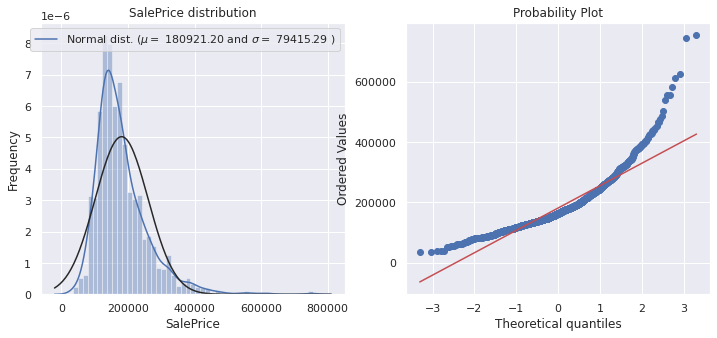

In [ ]:
# Target SalePrie
from scipy import stats
from scipy.stats import norm, skew #for some statistics

def feature_distribution(data):
  fig = plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  sns.distplot(data , fit=norm);
  # Get the fitted parameters used by the function
  (mu, sigma) = norm.fit(data)
  print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
              loc='best')
  plt.ylabel('Frequency')
  plt.title('SalePrice distribution')
  plt.subplot(1,2,2)
  res = stats.probplot(data, plot=plt)

feature_distribution(train['SalePrice'])

- SalePrice chưa là phân phối chuẩn, đang bị lệch trái
- Đỉnh khá cao
- Có giá trị outliers nằm trên 500000

In [ ]:
# Kiểm tra kiểu dữ liệu
list(set(df.dtypes.tolist()))

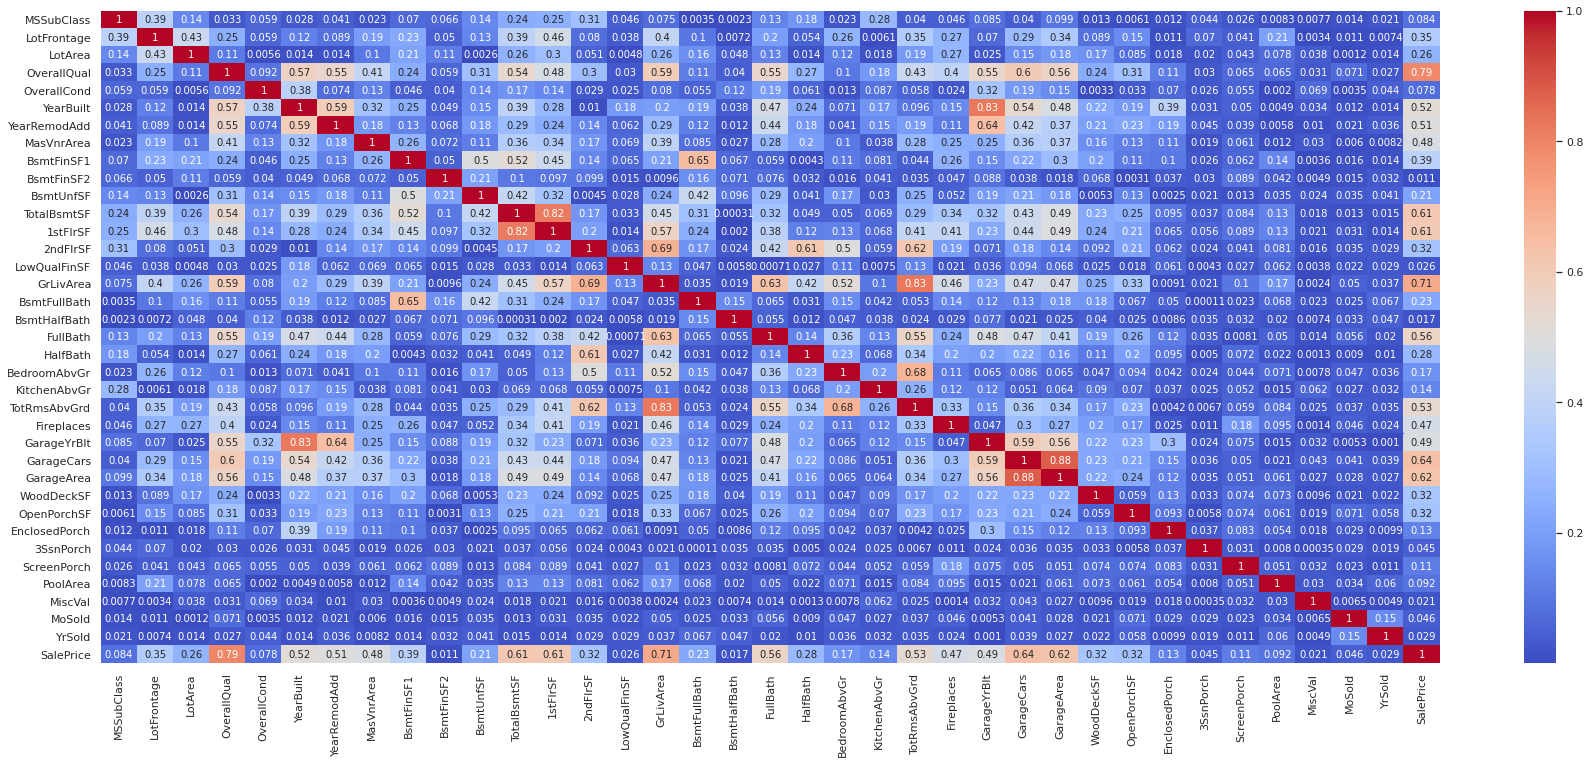

In [ ]:
# Correlation
corr = np.abs(train.corr())
plt.figure(figsize=(30,12))
sns.heatmap(corr,cmap='coolwarm',annot = True)
plt.show()

## Find Missing value

In [ ]:
def features_null(df):
  features_with_na = [x for x in train.columns if train[x].isnull().sum()>0]
  print('No. features_with_na = ' + str(len(features_with_na)))
  print('Total NaN = ' + str(train.isnull().values.sum()))
  return features_with_na

features_with_na = features_null(train)
describe_train[describe_train.index.isin(features_with_na)]

No. features_with_na = 19
Total NaN = 6965


,count,percent_null,unique,data_type,min,max,std,Description
Alley,91,93.767123,2,object,NaN,NaN,NaN,Type of alley access
BsmtCond,1423,2.534247,4,object,NaN,NaN,NaN,General condition of the basement
BsmtExposure,1422,2.602740,4,object,NaN,NaN,NaN,Walkout or garden level basement walls
BsmtFinType1,1423,2.534247,6,object,NaN,NaN,NaN,Quality of basement finished area
BsmtFinType2,1422,2.602740,6,object,NaN,NaN,NaN,Quality of second finished area (if present)
BsmtQual,1423,2.534247,4,object,NaN,NaN,NaN,Height of the basement
Electrical,1459,0.068493,5,object,NaN,NaN,NaN,Electrical system
Fence,281,80.753425,4,object,NaN,NaN,NaN,Fence quality
FireplaceQu,770,47.260274,5,object,NaN,NaN,NaN,Fireplace quality
GarageCond,1379,5.547945,5,object,NaN,NaN,NaN,Garage condition


- 'PoolQC', 'MiscFeature', 'Alley', 'Fence' có giá trị null rất cao. Theo mô tả data thì các giá trị null đại diện rằng không có các đặc trưng đó
- 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt'
- 'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual'

In [ ]:
# Phân loại numerical và non_numerical
def classify_numerical_feature(df):
  numerical = df.select_dtypes('number').columns
  non_numerical = df.select_dtypes(['category', 'object']).columns
  print('No. numerical_features = ' + str(len(numerical)))
  print('No. non_numerical_features = ' + str(len(non_numerical)))
  return numerical, non_numerical

numerical_features, non_numerical_features = classify_numerical_feature(train)  

No. numerical_features = 37
No. non_numerical_features = 43


In [ ]:
numerical_features = train.select_dtypes('number').columns
describe_train[describe_train.index.isin(numerical_features)]

,count,percent_null,unique,data_type,min,max,std,Description
1stFlrSF,1460,0.000000,753,int64,334,4692,386.587738,First Floor square feet
2ndFlrSF,1460,0.000000,417,int64,0,2065,436.528436,Second floor square feet
3SsnPorch,1460,0.000000,20,int64,0,508,29.317331,Three season porch area in square feet
BedroomAbvGr,1460,0.000000,8,int64,0,8,0.815778,Number of bedrooms above basement level
BsmtFinSF1,1460,0.000000,637,int64,0,5644,456.098091,Type 1 finished square feet
BsmtFinSF2,1460,0.000000,144,int64,0,1474,161.319273,Type 2 finished square feet
BsmtFullBath,1460,0.000000,4,int64,0,3,0.518911,Basement full bathrooms
BsmtHalfBath,1460,0.000000,3,int64,0,2,0.238753,Basement half bathrooms
BsmtUnfSF,1460,0.000000,780,int64,0,2336,441.866955,Unfinished square feet of basement area
EnclosedPorch,1460,0.000000,120,int64,0,552,61.119149,Enclosed porch area in square feet


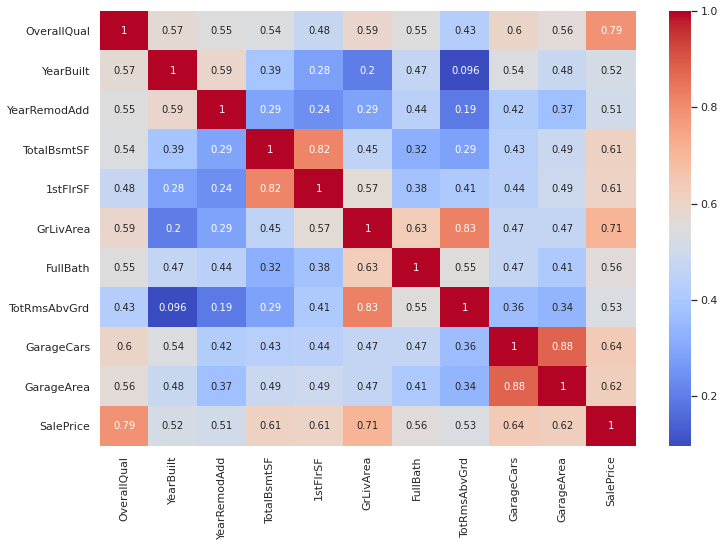

In [ ]:
top_feature = corr.index[abs(corr['SalePrice']>0.5)]
plt.subplots(figsize=(12, 8))
top_corr = train[top_feature].corr()
sns.heatmap(top_corr, cmap='coolwarm',annot=True)
plt.show()

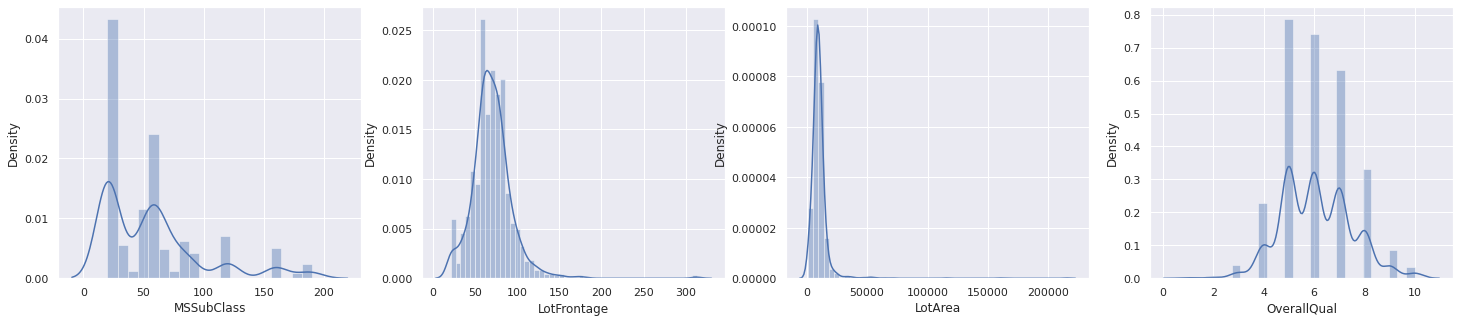

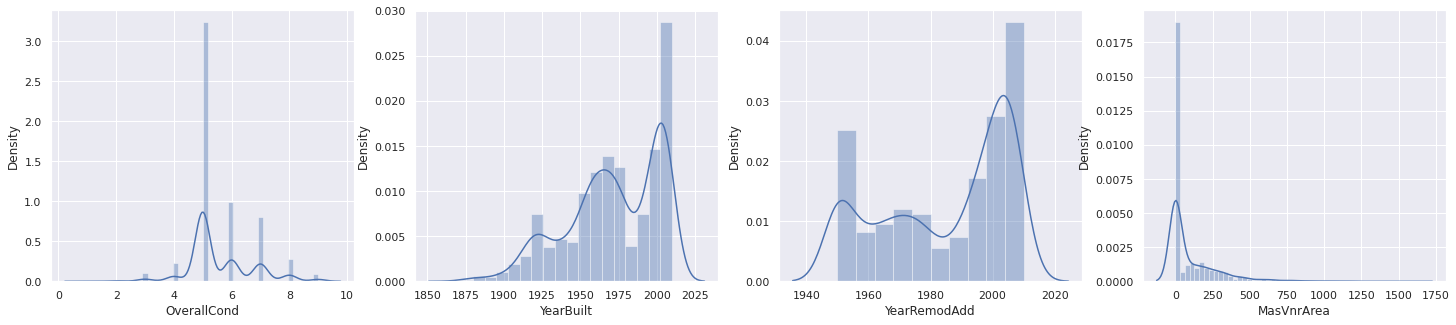

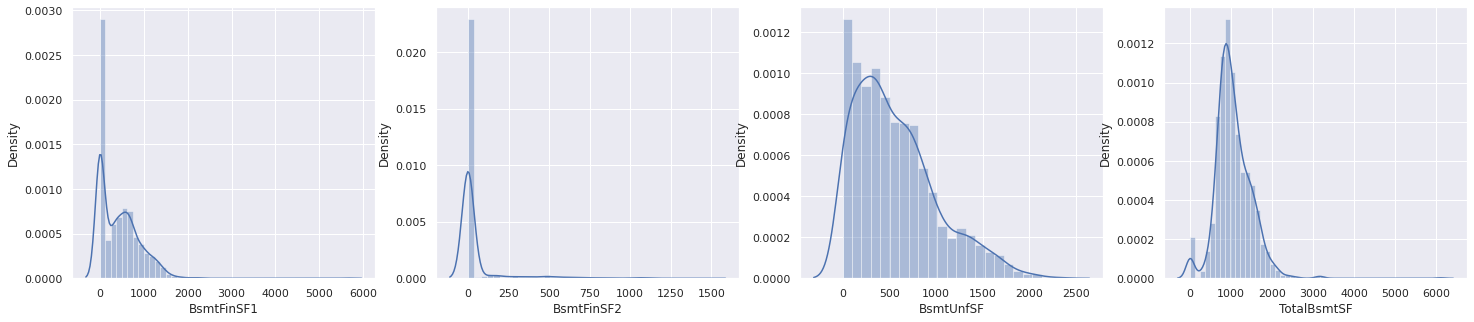

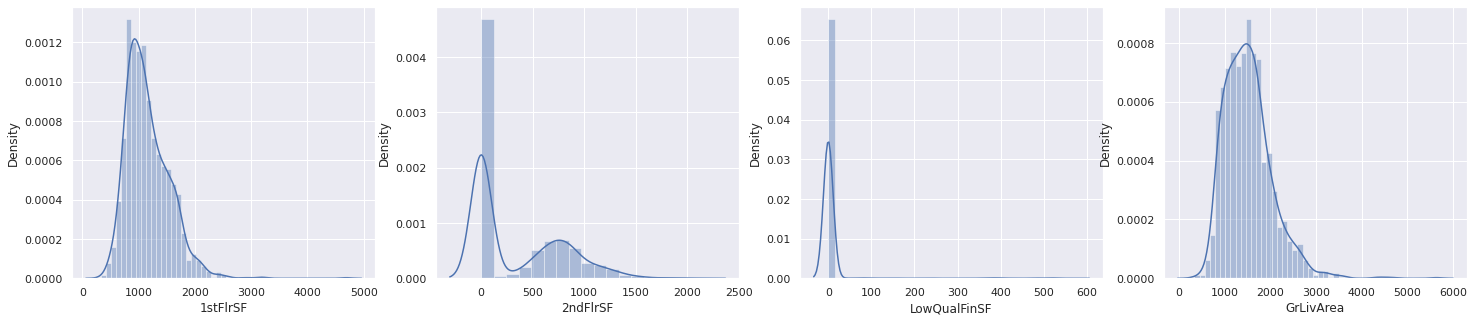

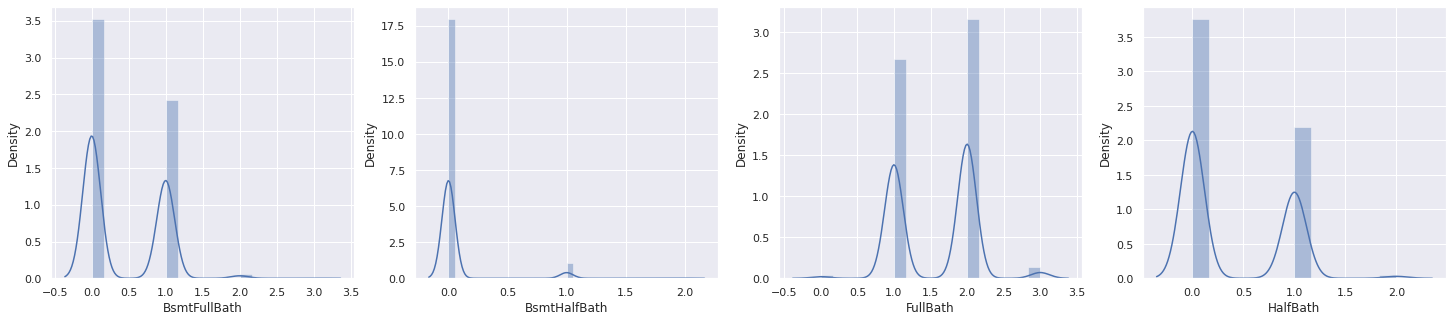

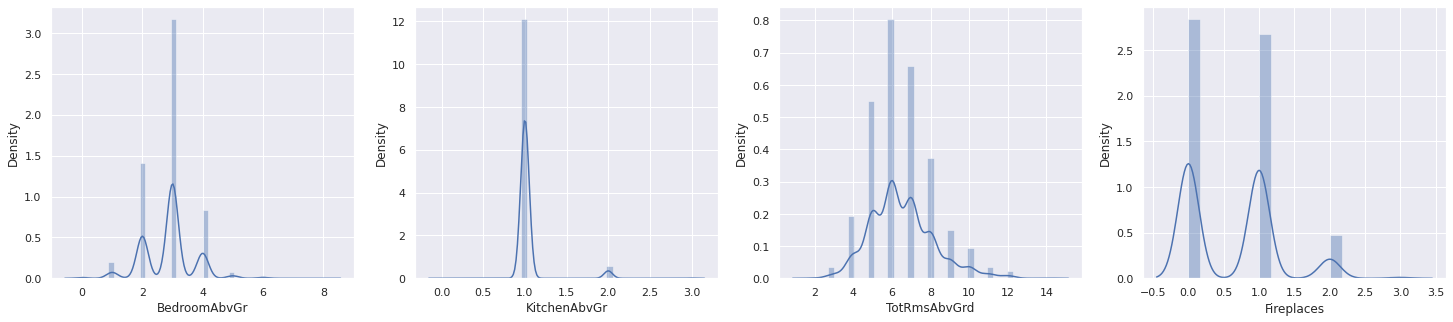

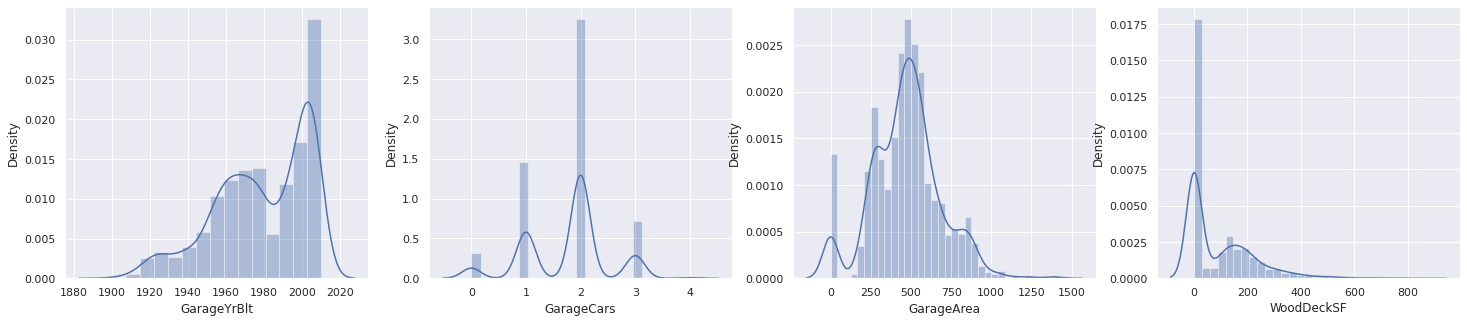

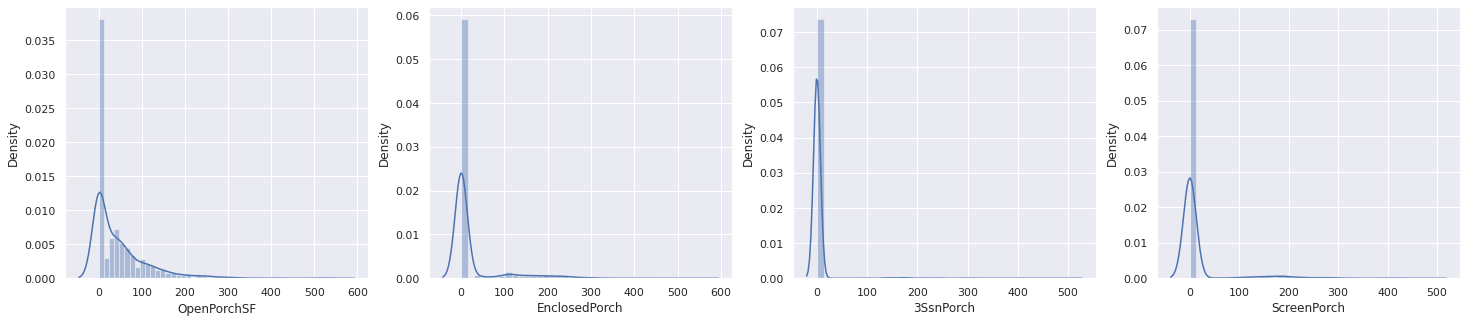

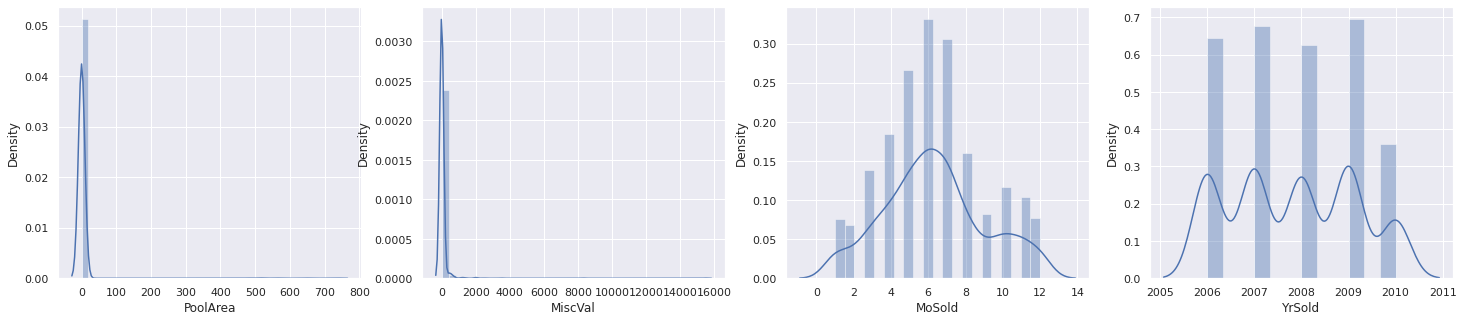

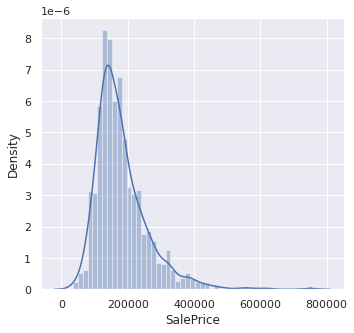

In [ ]:
# Distribution numerical feature
count = 0
for feature in numerical_features:
    plt.figure(count//4,figsize=(25,5))
    plt.subplot(1,4,np.mod(count,4)+1)

    sns.distplot(train[feature])
    plt.xlabel(feature)
    count += 1


- Một số feature có giá trị 0 rất cao: 'MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'BsmtHlfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PollArea', 'MiscVal'
- Một số feature tập trung tại một số giá trị nhất định: 'OveralCond', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr'
- Số lượng nhà mua-bán qua các năm nhiều hơn vào giữa năm so với đầu và cuối năm
- Số lượng nhà được xây có xu hướng tăng dần đến năm 1975 và giảm đột ngột và tăng cao vào năm 2000

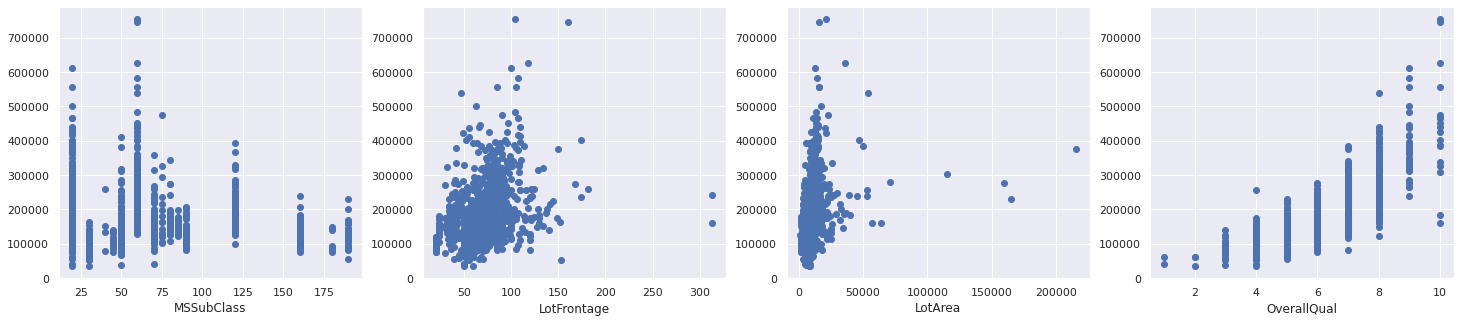

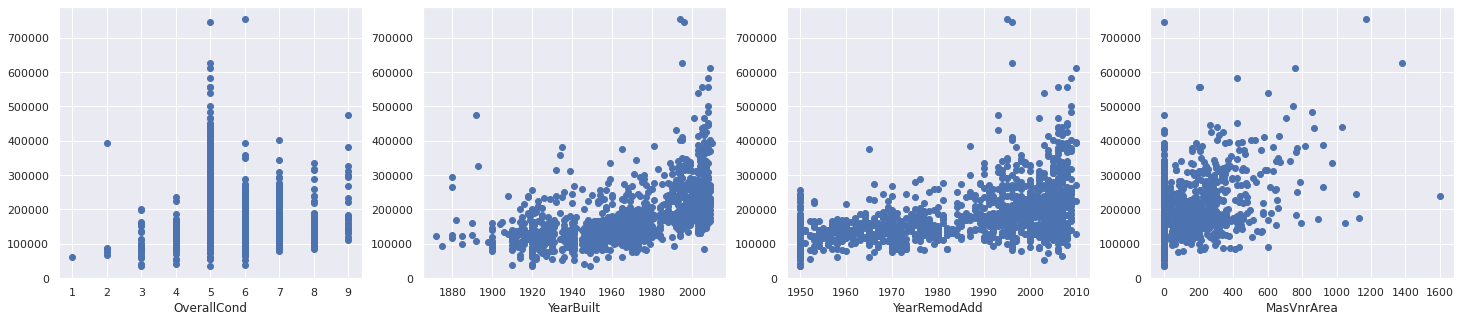

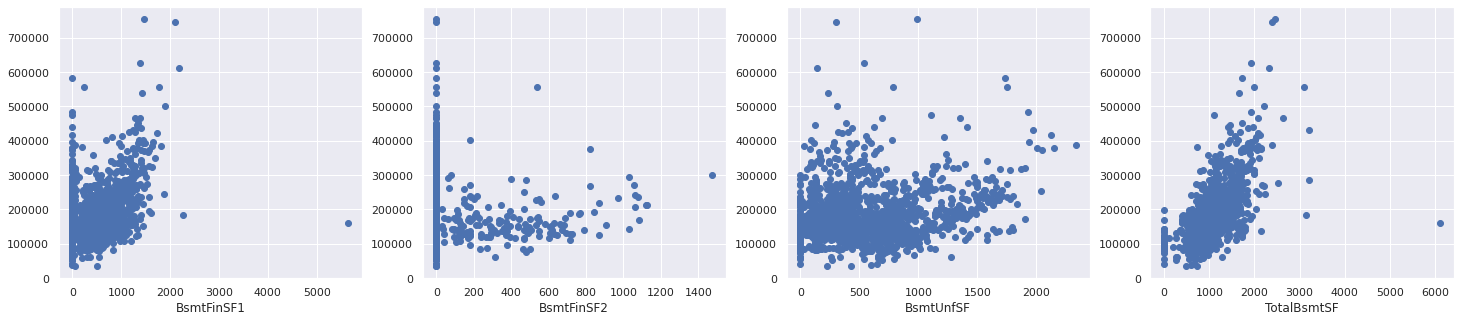

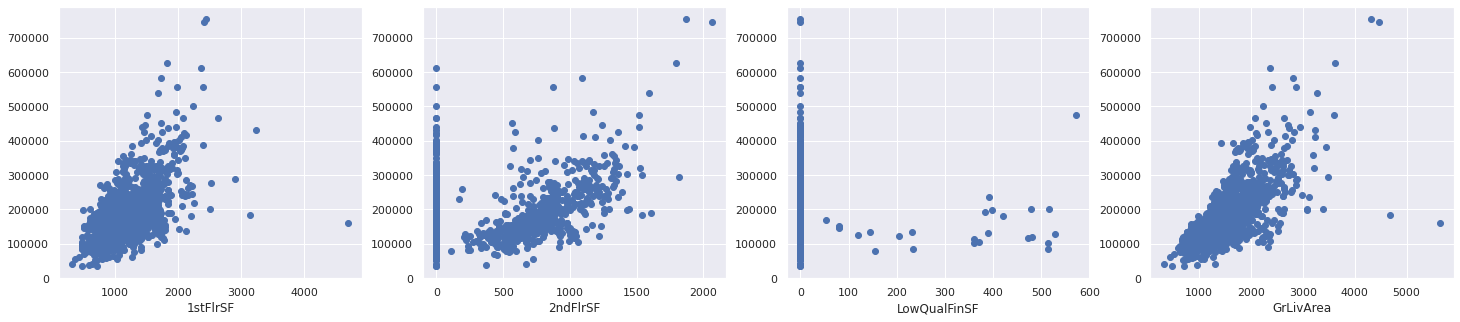

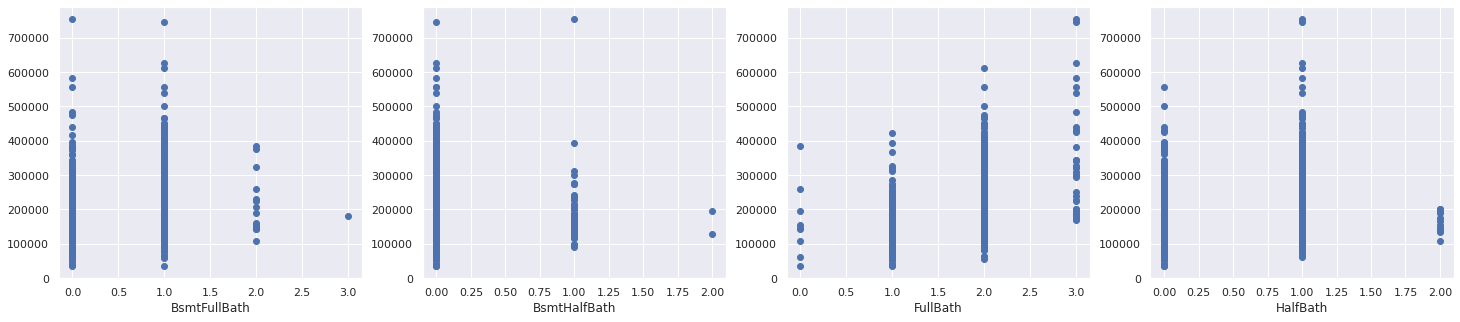

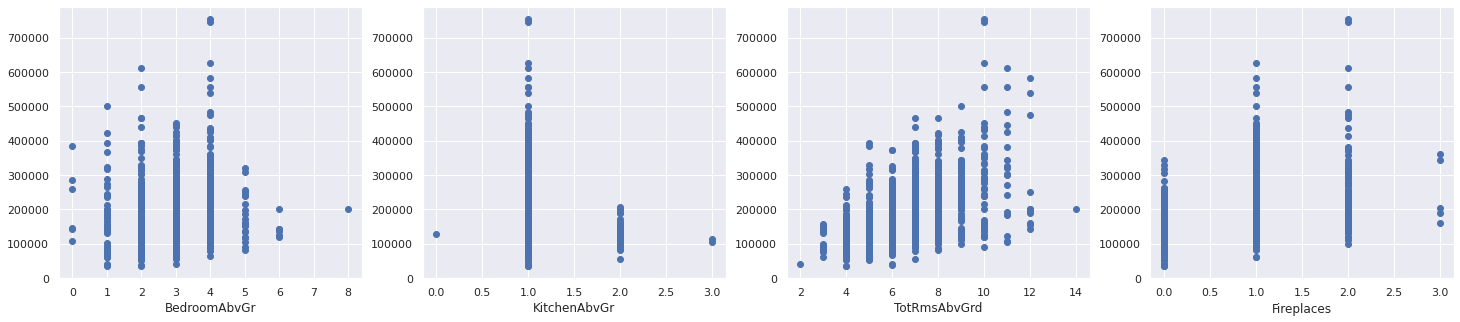

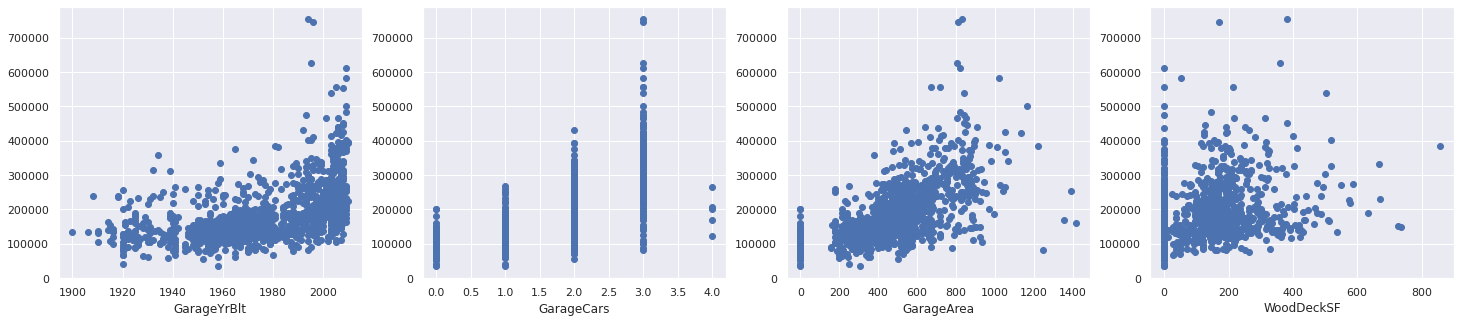

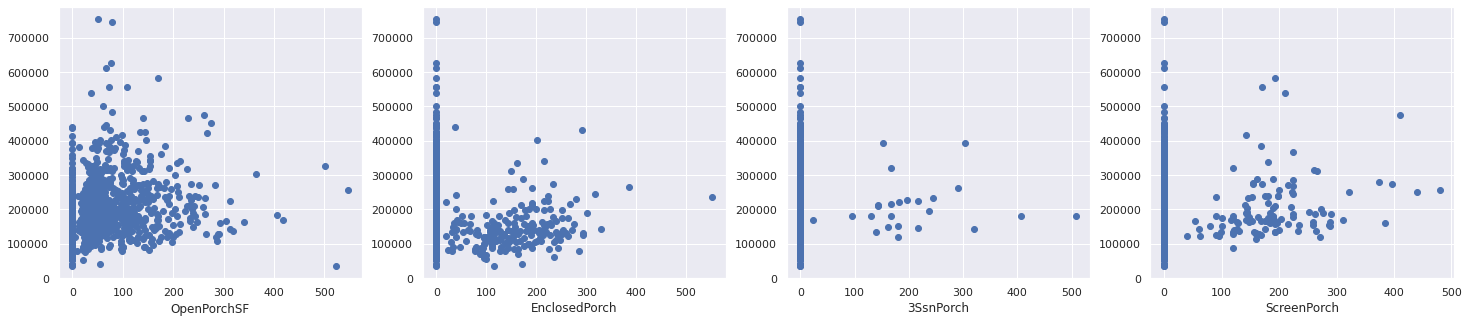

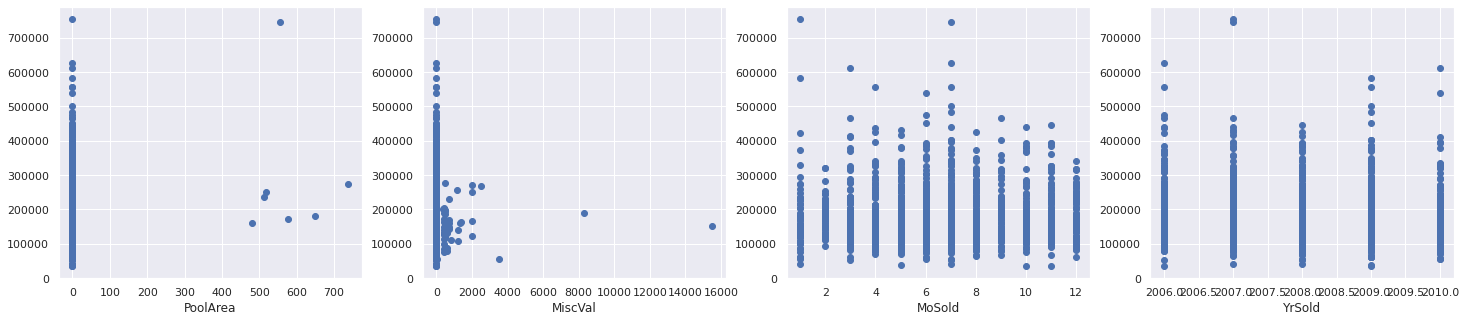

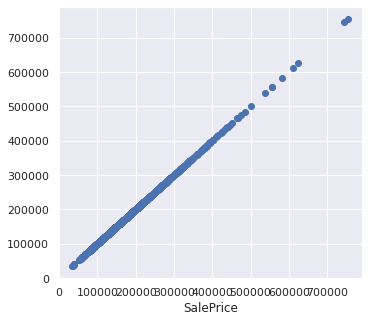

In [ ]:
# Function show scatter
def scatter_with_feature(df, features, feature_target, figures_per_time = 4):
  count = 0
  for feature in features:
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,figures_per_time)+1)
    plt.scatter(x= feature, y=feature_target, data = df)
    plt.xlabel(feature)
    count += 1

scatter_with_feature(train, numerical_features, 'SalePrice')

- 'SalePrice' có vẻ có quan hệ tuyến tính với một vài feature

In [ ]:
describe_train[describe_train.index.isin(non_numerical_features)]

,count,percent_null,unique,data_type,min,max,std,Description
Alley,91,93.767123,2,object,NaN,NaN,NaN,Type of alley access
BldgType,1460,0.000000,5,object,1Fam,TwnhsE,NaN,Type of dwelling
BsmtCond,1423,2.534247,4,object,NaN,NaN,NaN,General condition of the basement
BsmtExposure,1422,2.602740,4,object,NaN,NaN,NaN,Walkout or garden level basement walls
BsmtFinType1,1423,2.534247,6,object,NaN,NaN,NaN,Quality of basement finished area
BsmtFinType2,1422,2.602740,6,object,NaN,NaN,NaN,Quality of second finished area (if present)
BsmtQual,1423,2.534247,4,object,NaN,NaN,NaN,Height of the basement
CentralAir,1460,0.000000,2,object,N,Y,NaN,Central air conditioning
Condition1,1460,0.000000,9,object,Artery,RRNn,NaN,Proximity to main road or railroad
Condition2,1460,0.000000,8,object,Artery,RRNn,NaN,Proximity to main road or railroad (if a secon...


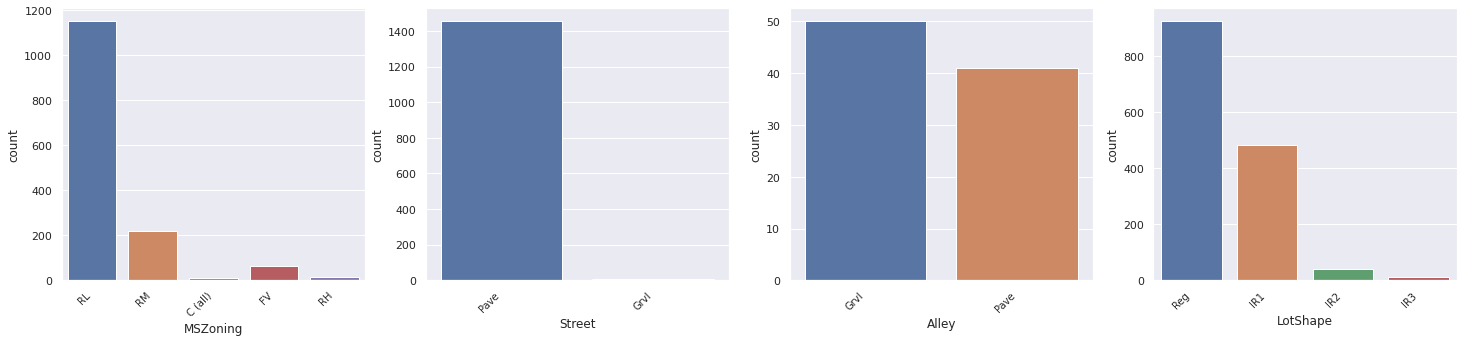

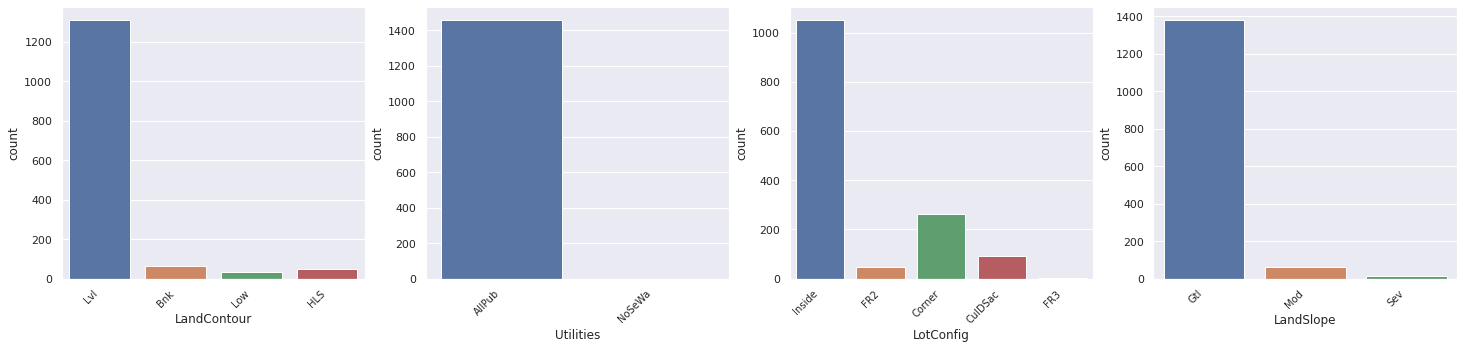

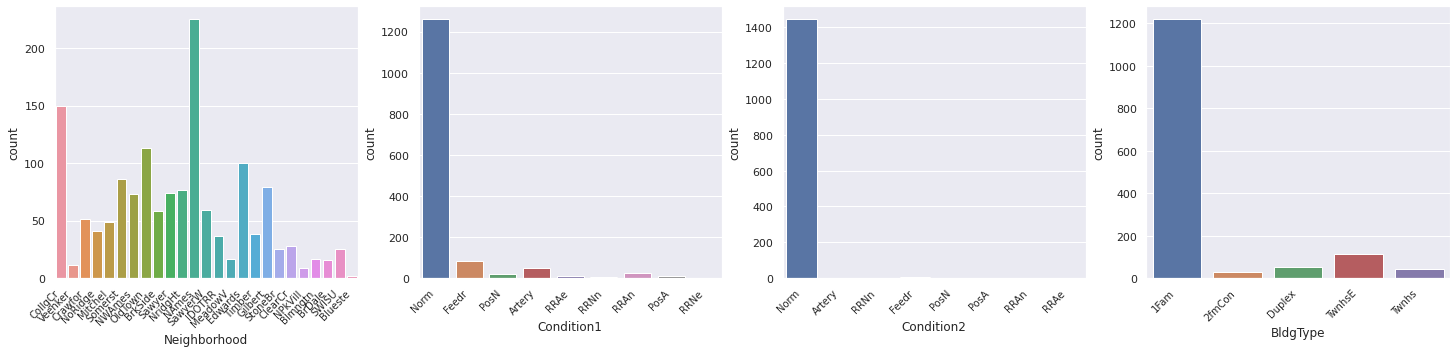

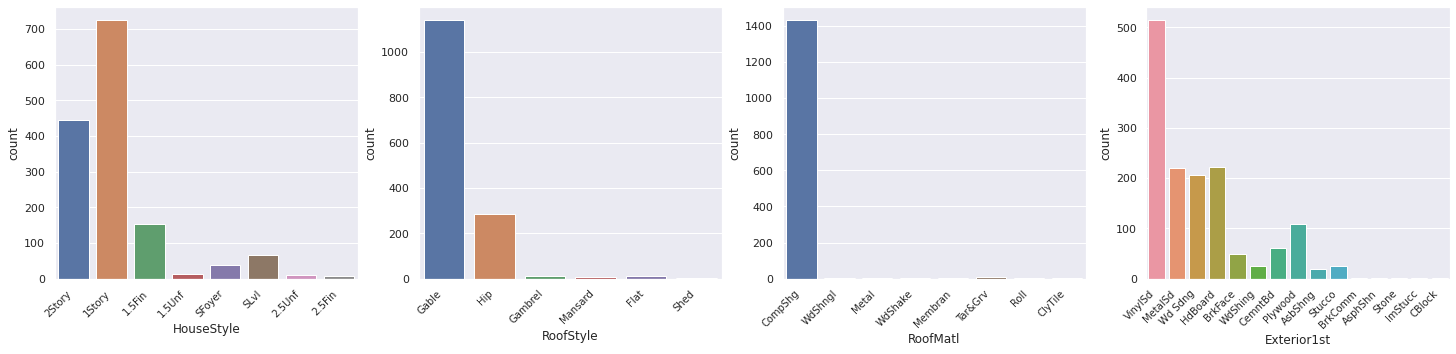

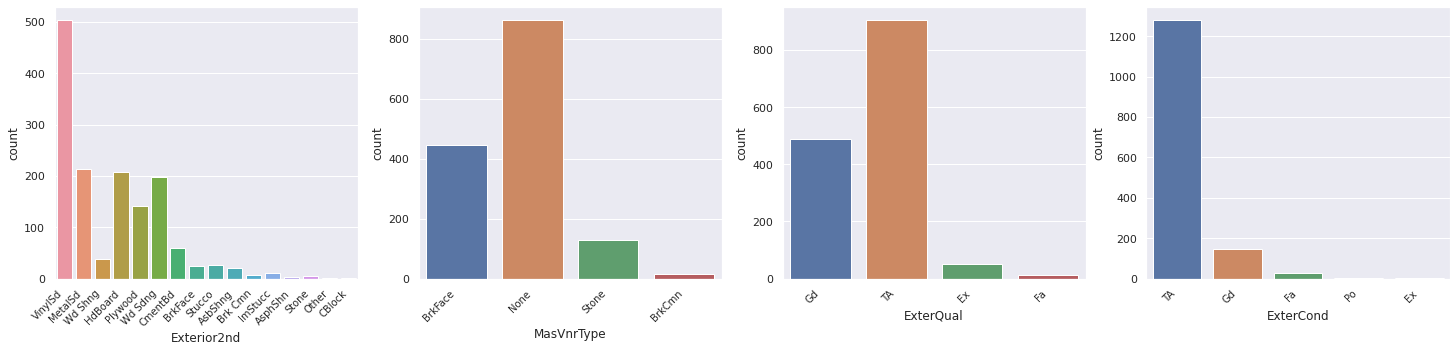

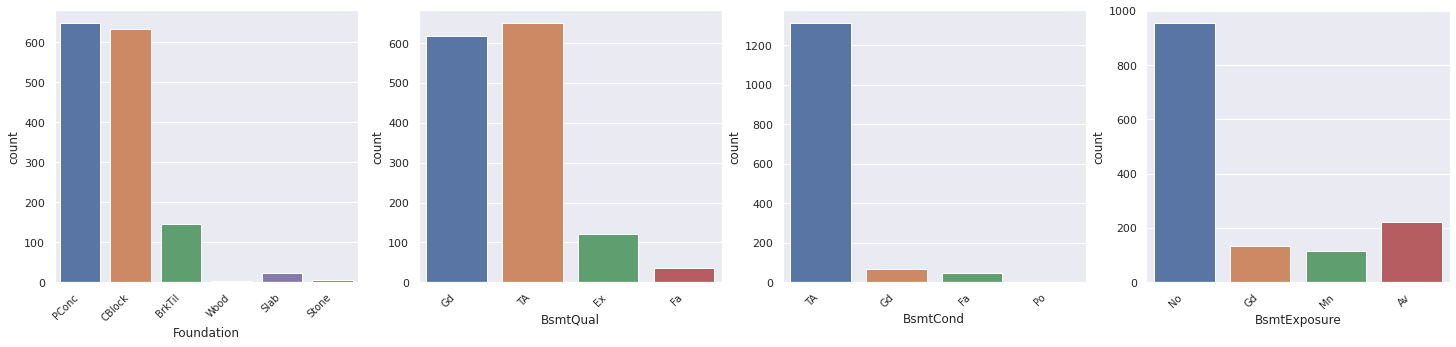

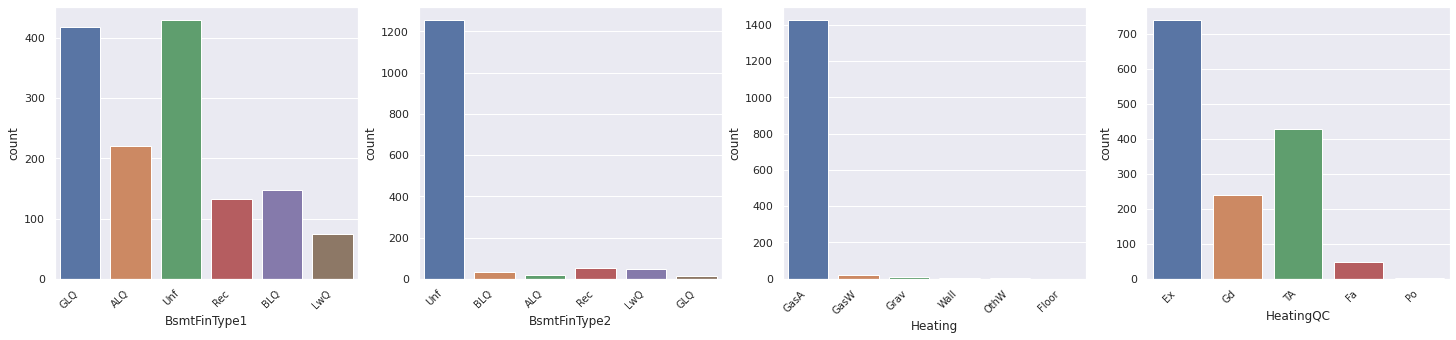

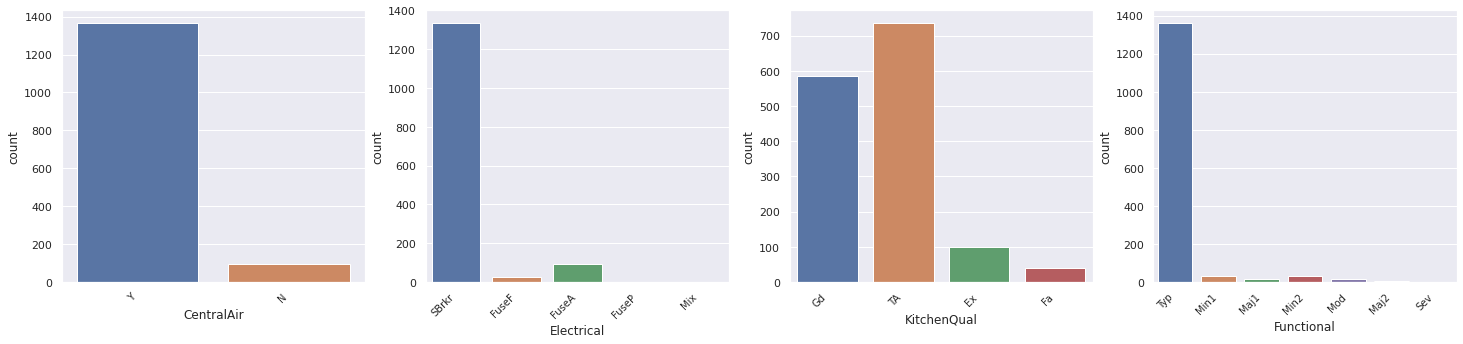

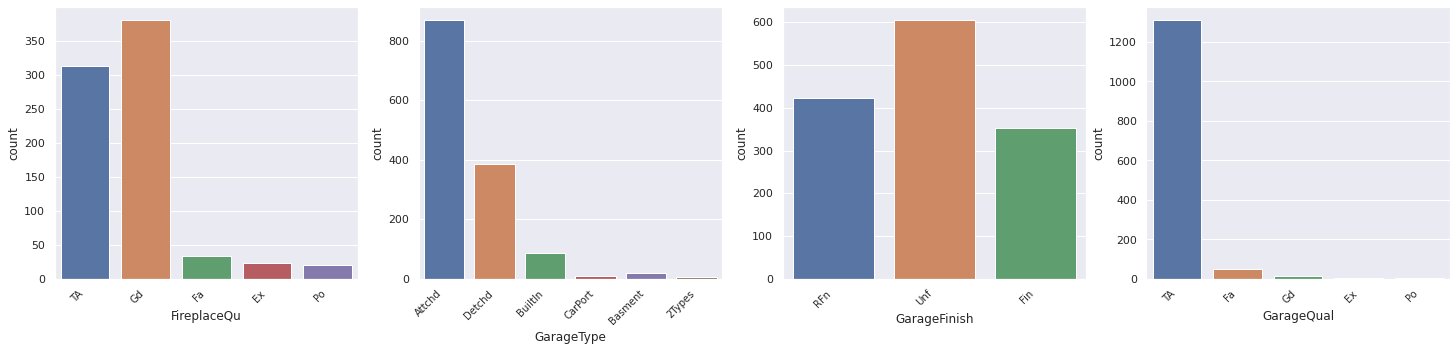

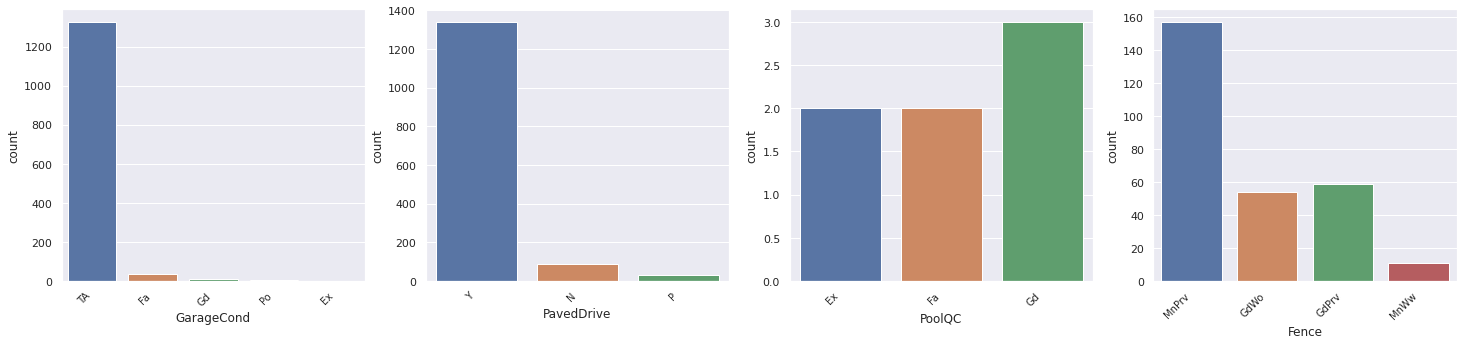

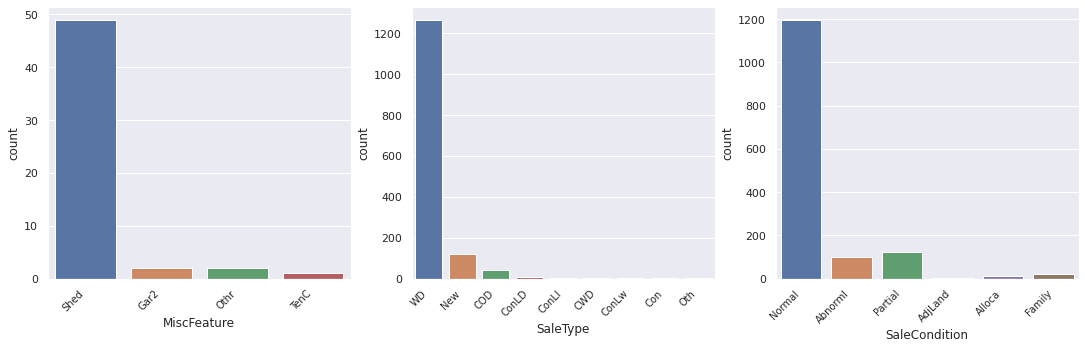

In [ ]:
# Distribution non_numerical feature
def countplot_features(df, features):
  count = 0
  for feature in features:
      plt.figure(count//4,figsize=(25,5))
      plt.subplot(1,4,np.mod(count,4)+1)

      sns.countplot(df[feature])
      plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium'  
        )
      plt.xlabel(feature)
      count += 1

countplot_features(train, non_numerical_features)

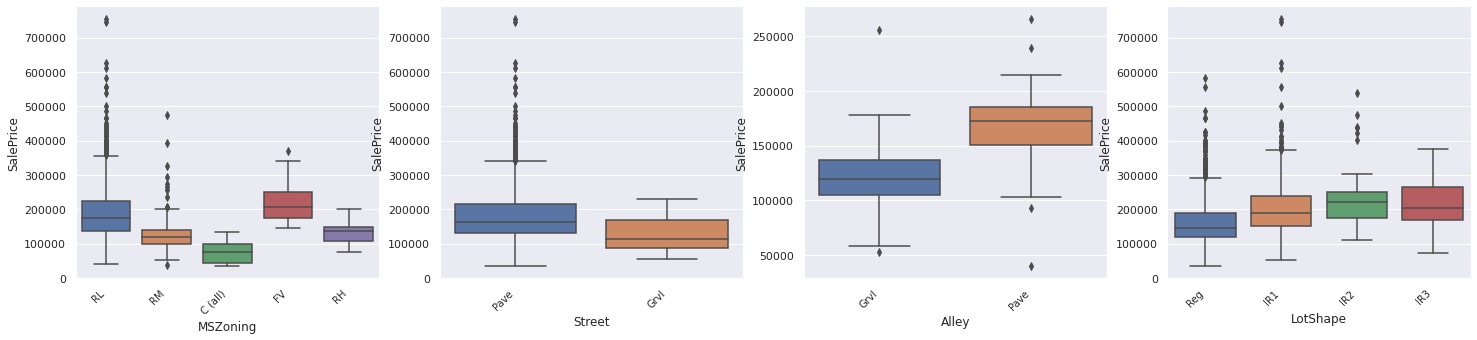

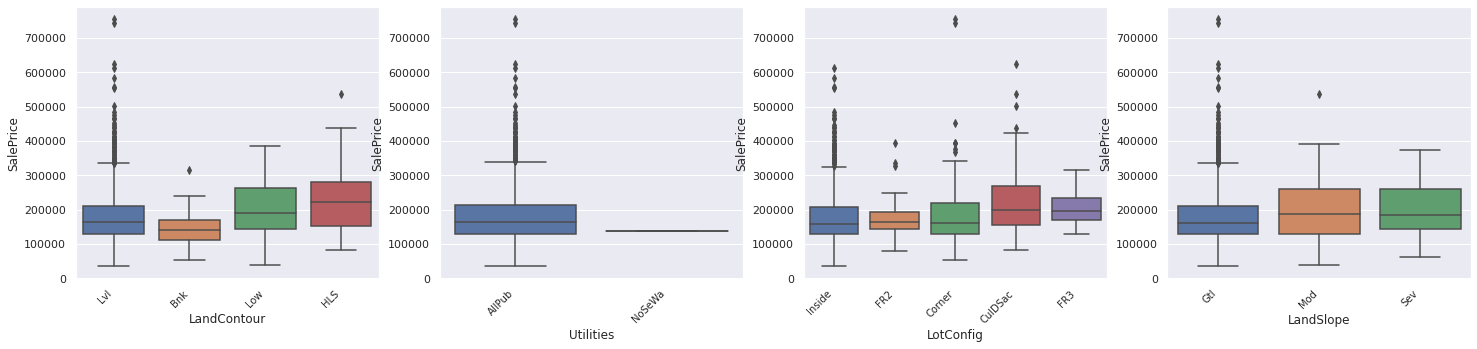

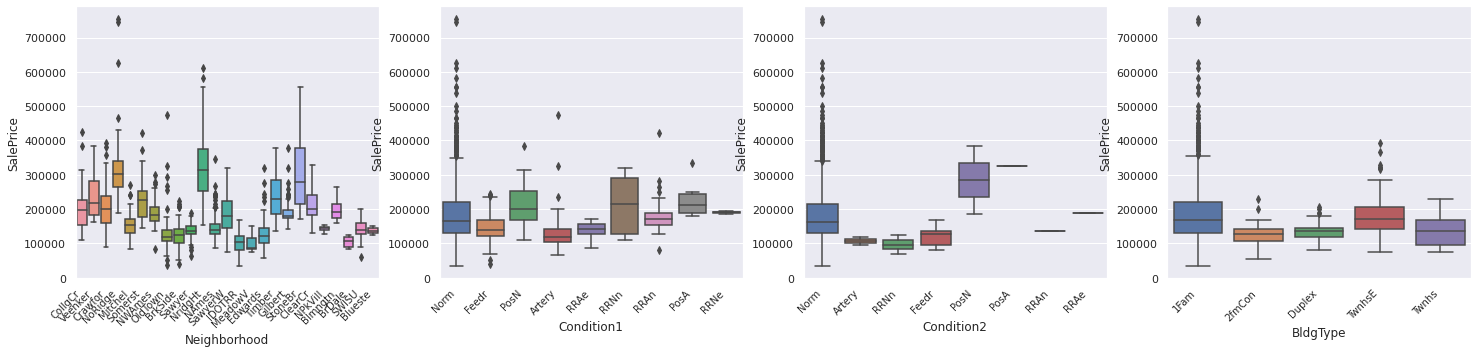

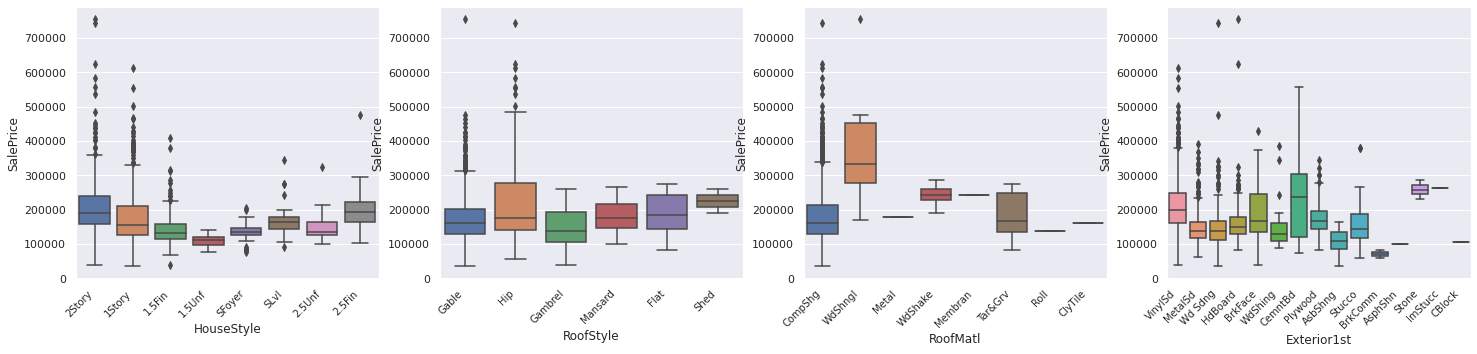

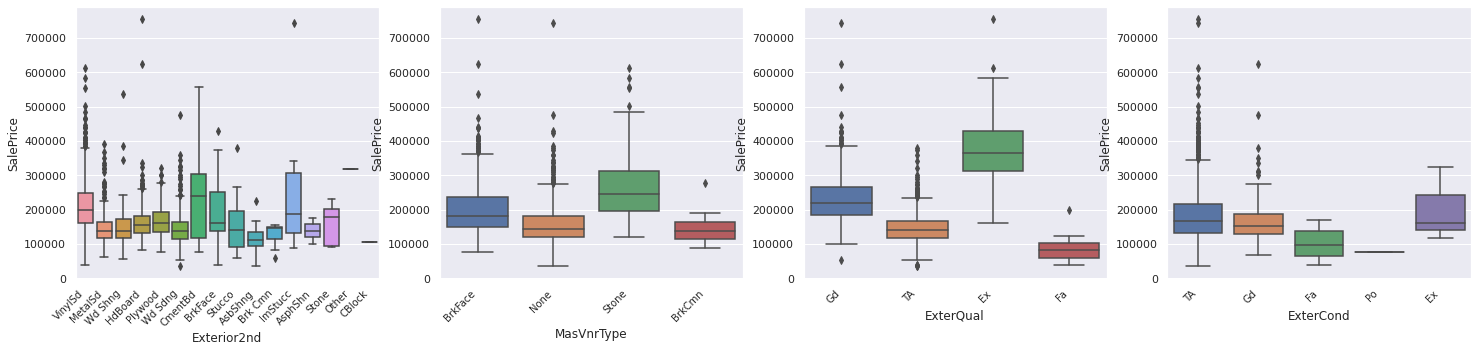

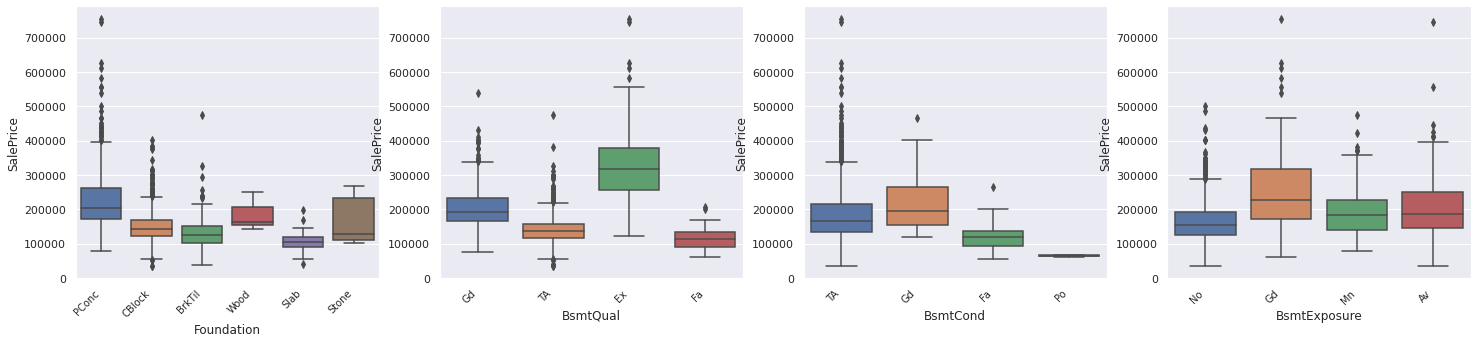

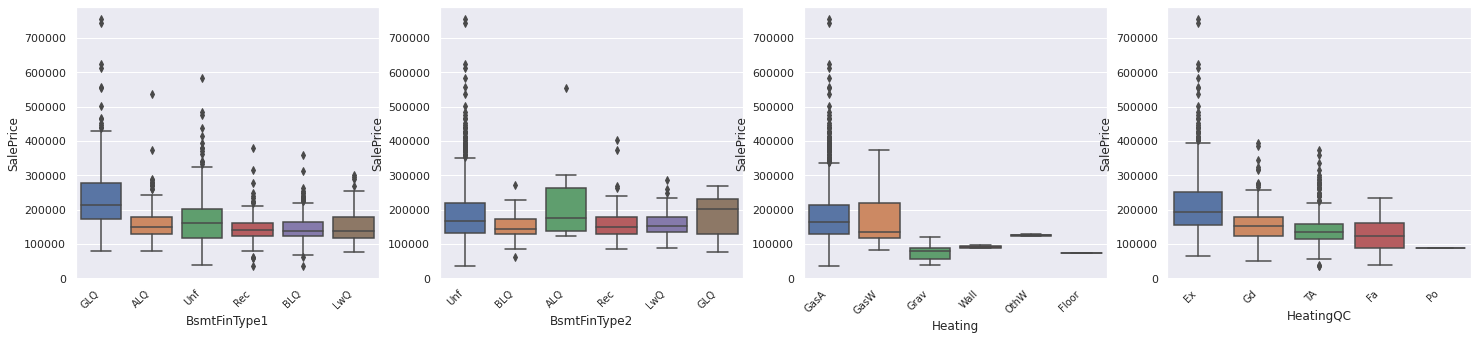

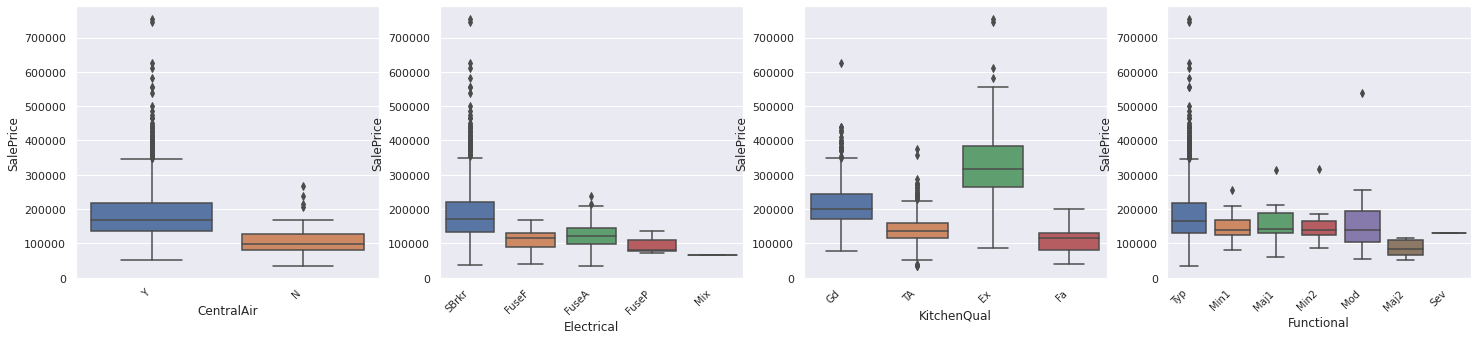

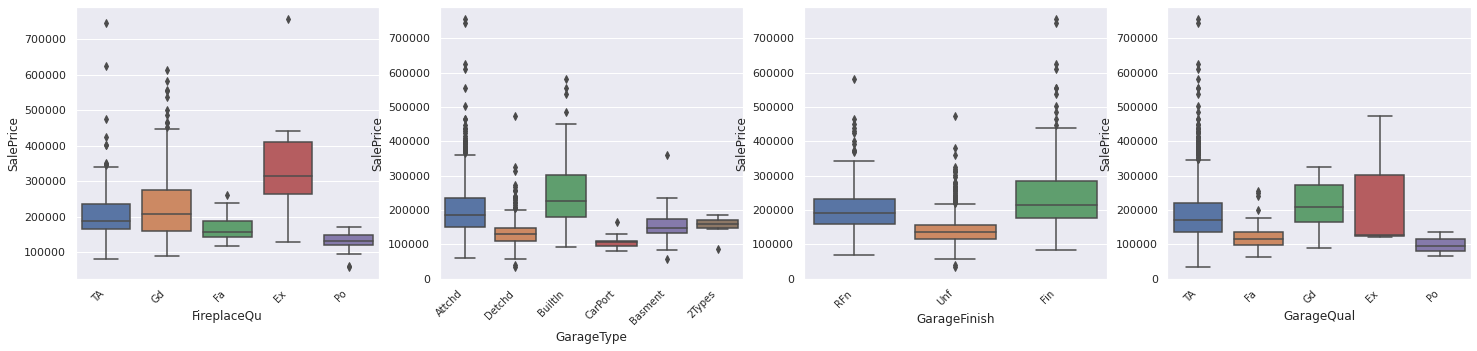

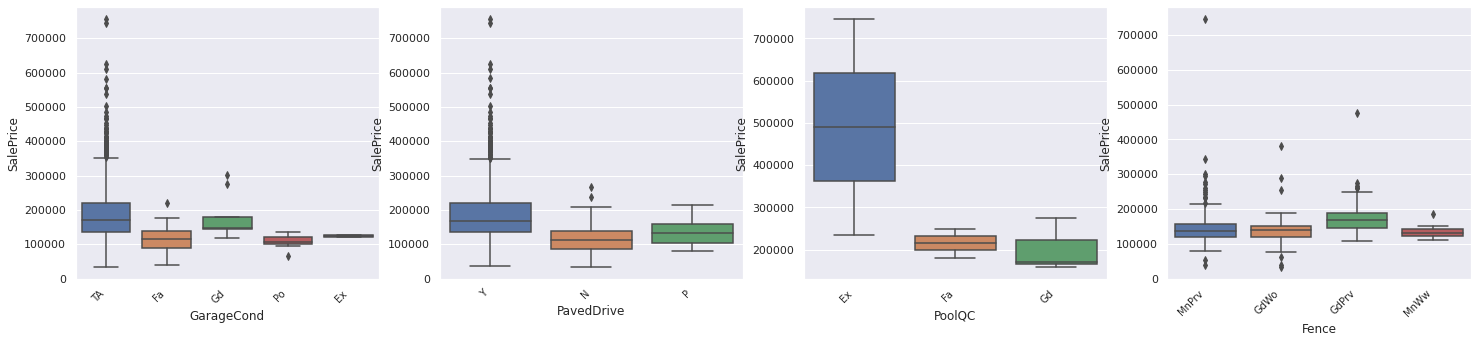

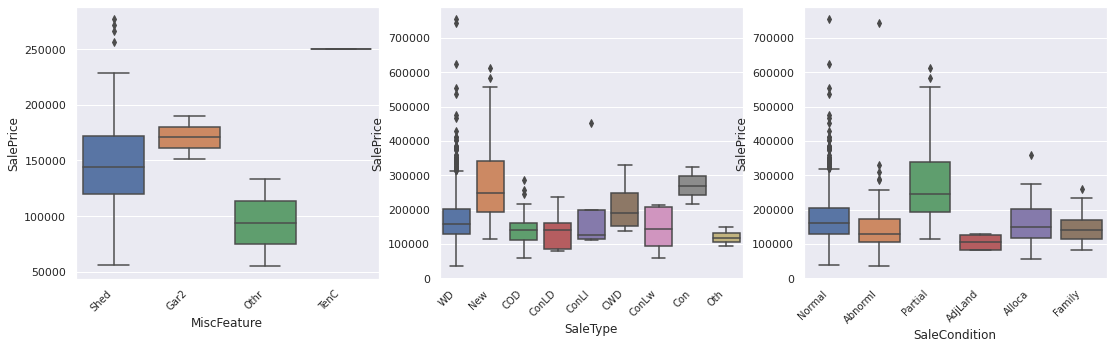

In [ ]:
def boxplot_with_features(df, features, target,figures_per_time = 4):
  count = 0
  for feature in features:
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,figures_per_time)+1)

    sns.boxplot(x=feature, y=target, data=df)
    plt.xticks(
      rotation=45, 
      horizontalalignment='right',
      fontweight='light',
      fontsize='medium'  
      )
    count += 1

boxplot_with_features(train, non_numerical_features, 'SalePrice')

In [ ]:
quantitative_features_list = [
                              'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
                              '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                              'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'
                              ]
train[quantitative_features_list].head()


,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,706,0,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,978,0,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,486,0,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,216,0,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,655,0,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000


# 2. Data cleaning

## Handling Missing value

In [ ]:
# missing value in numerical_columns
numerical_features_na = [x for x in features_with_na if x in numerical_features]
describe_train[describe_train.index.isin(numerical_features_na)]

,count,percent_null,unique,data_type,min,max,std,Description
GarageYrBlt,1379,5.547945,97,float64,1900,2010,24.689725,Year garage was built
LotFrontage,1201,17.739726,110,float64,21,313,24.284752,Linear feet of street connected to property
MasVnrArea,1452,0.547945,327,float64,0,1600,181.066207,Masonry veneer area in square feet


In [ ]:
# Replace 'LotFrontage' base on Neighborhood
train['LotFrontage'] = train.groupby('Neighborhood')["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [ ]:
# GarageYrBlt replace with 0
train['GarageYrBlt'].fillna(0, inplace=True)

#MasVnrArea : replace with 0
train['MasVnrArea'].fillna(0, inplace = True)

In [ ]:
train[numerical_features_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [ ]:
# missing value in non_numerical_columns
non_numerical_features_na = [x for x in features_with_na if x in non_numerical_features]
describe_train[describe_train.index.isin(non_numerical_features_na)]

,count,percent_null,unique,data_type,min,max,std,Description
Alley,91,93.767123,2,object,NaN,NaN,NaN,Type of alley access
BsmtCond,1423,2.534247,4,object,NaN,NaN,NaN,General condition of the basement
BsmtExposure,1422,2.602740,4,object,NaN,NaN,NaN,Walkout or garden level basement walls
BsmtFinType1,1423,2.534247,6,object,NaN,NaN,NaN,Quality of basement finished area
BsmtFinType2,1422,2.602740,6,object,NaN,NaN,NaN,Quality of second finished area (if present)
BsmtQual,1423,2.534247,4,object,NaN,NaN,NaN,Height of the basement
Electrical,1459,0.068493,5,object,NaN,NaN,NaN,Electrical system
Fence,281,80.753425,4,object,NaN,NaN,NaN,Fence quality
FireplaceQu,770,47.260274,5,object,NaN,NaN,NaN,Fireplace quality
GarageCond,1379,5.547945,5,object,NaN,NaN,NaN,Garage condition


In [ ]:
train['Electrical'].fillna(train['Electrical'].mode()[0], inplace=True)

In [ ]:
# Missing data filling
train[non_numerical_features_na] = train[non_numerical_features_na].fillna('None')

In [ ]:
features_null(train)

No. features_with_na = 0
Total NaN = 0


[]

## Feature Engineering

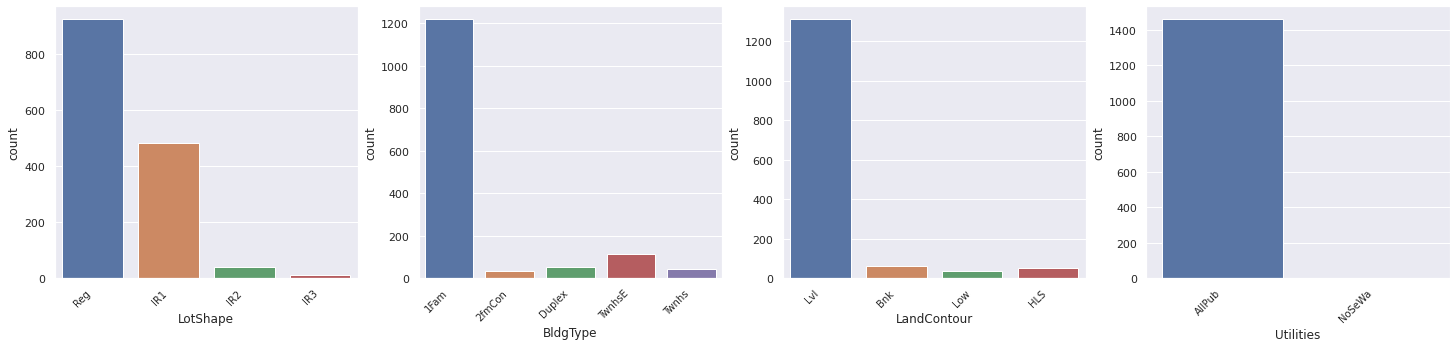

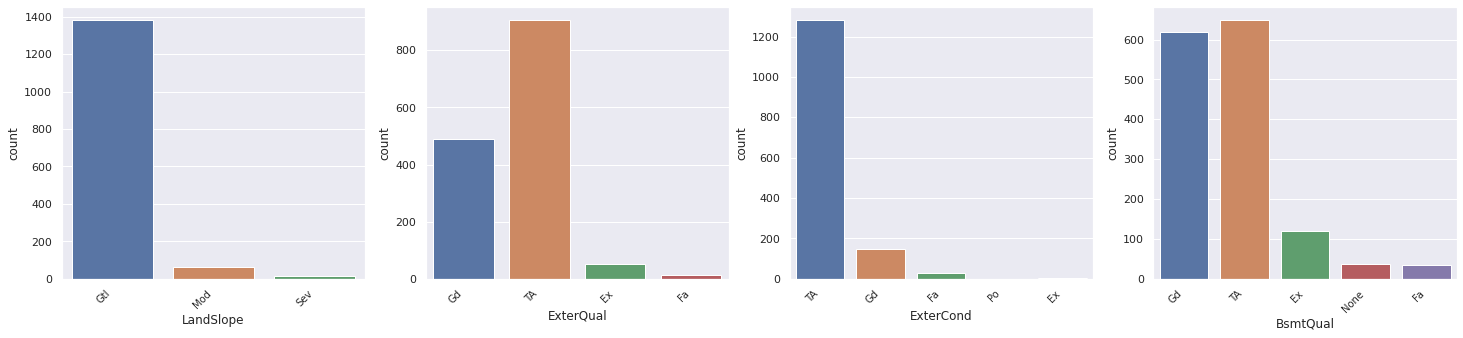

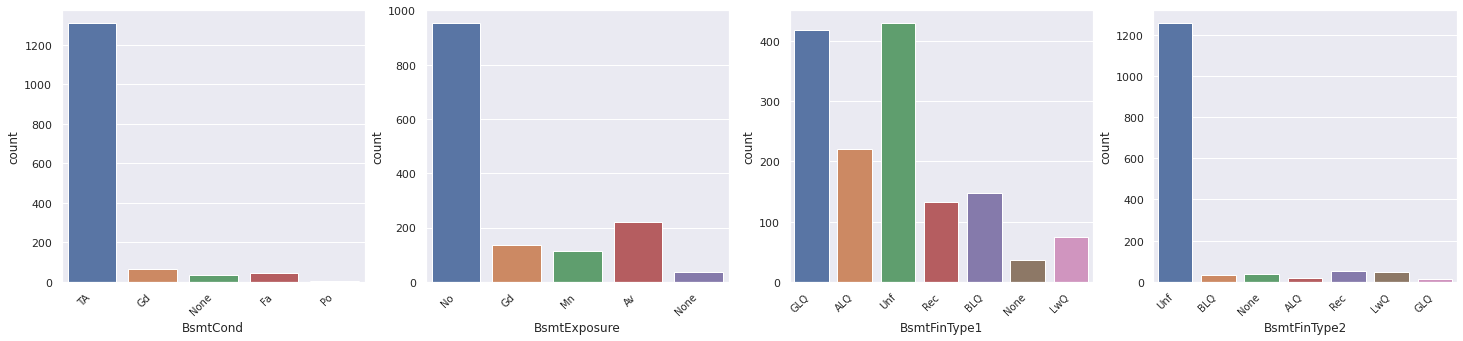

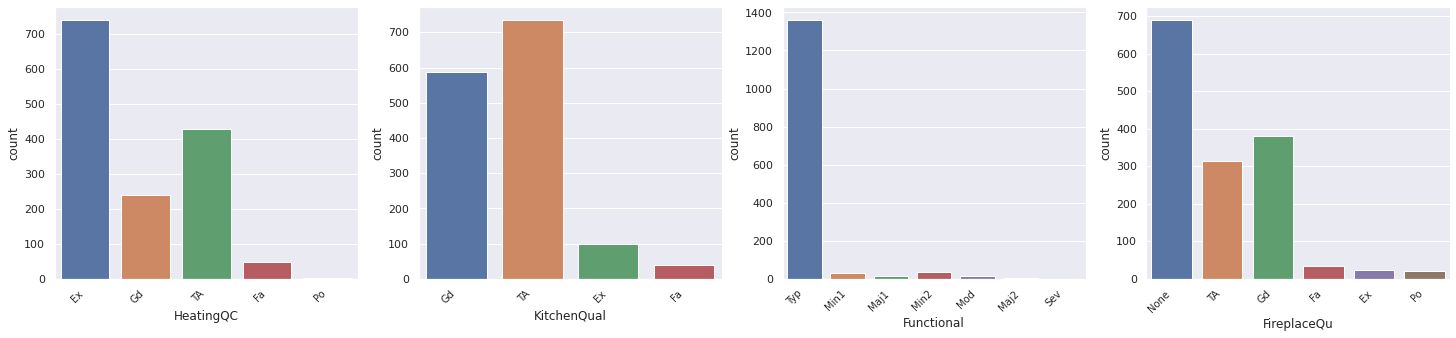

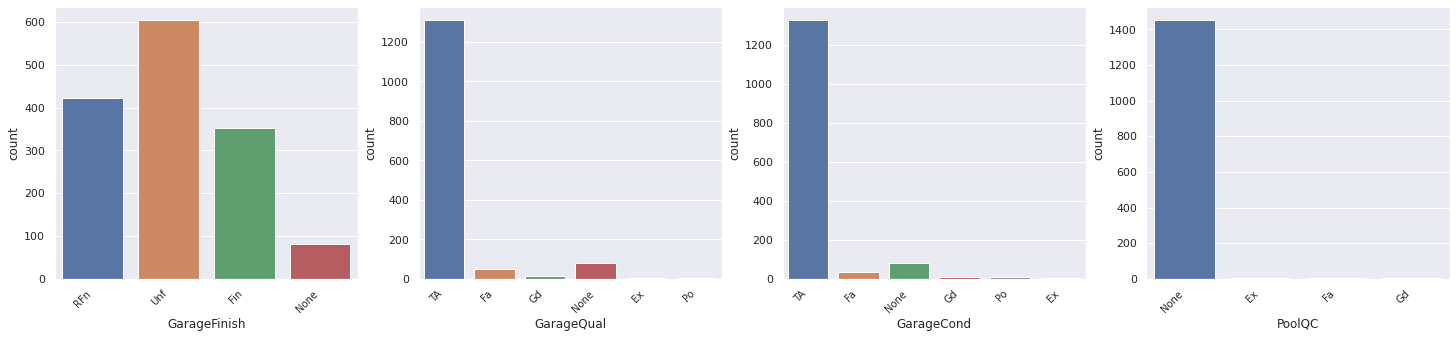

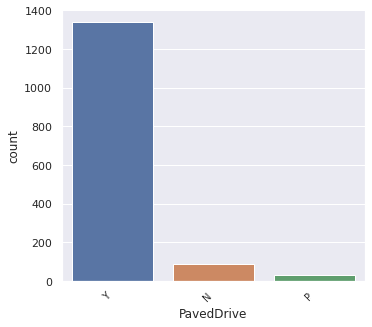

In [ ]:
non_num_to_num = ['LotShape', 'BldgType', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 
 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'PavedDrive']

countplot_features(train, non_num_to_num)

In [ ]:
for x in non_num_to_num:
  print(x, train[x].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'None' 'Fa']
BsmtCond ['TA' 'Gd' 'None' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
FireplaceQu ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'None']
GarageQual ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
PoolQC ['None' 'Ex' 'Fa' 'Gd']
PavedDrive ['Y' 'N' 'P']


In [ ]:
train['LotShape'].replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
train['BldgType'].replace({'1Fam':1, '2fmCon':1, 'Duplex':3, 'TwnhsE':4, 'Twnhs':5}, inplace=True)
train['LandContour'].replace({ 'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)
train['Utilities'].replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
train['LandSlope'].replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)
train['ExterQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['ExterCond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['BsmtQual'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['BsmtCond'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
train['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
train['BsmtFinType2'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
train['HeatingQC'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['KitchenQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['Functional'].replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
train['FireplaceQu'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['GarageFinish'].replace({'None':0, 'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
train['GarageQual'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['GarageCond'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['PoolQC'].replace({'None':0, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train['PavedDrive'].replace({'N':1, 'P':2, 'Y':3}, inplace=True)



In [ ]:
for x in non_num_to_num:
  print(x, train[x].unique())

LotShape [1 2 3 4]
BldgType [1 3 4 5]
LandContour [4 3 1 2]
Utilities [4 2]
LandSlope [3 2 1]
ExterQual [4 3 5 2]
ExterCond [3 4 2 1 5]
BsmtQual [4 3 5 0 2]
BsmtCond [3 4 0 2 1]
BsmtExposure [1 4 2 3 0]
BsmtFinType1 [6 5 1 3 4 0 2]
BsmtFinType2 [1 4 0 5 3 2 6]
HeatingQC [5 4 3 2 1]
KitchenQual [4 3 5 2]
Functional [8 7 4 6 5 3 2]
FireplaceQu [0 3 4 2 5 1]
GarageFinish [2 1 3 0]
GarageQual [3 2 4 0 5 1]
GarageCond [3 2 0 4 1 5]
PoolQC [0 5 2 4]
PavedDrive [3 1 2]


In [ ]:
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
numerical_features =train.select_dtypes('number').columns
print('Total features = ' + str(len(train.columns)))
print('No. Numerical_features = ' + str(len(numerical_features)))
train.head()

Total features = 82
No. Numerical_features = 60


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage,HasBasement
0,60,RL,65.0,8450,Pave,None,1,4,4,Inside,3,CollgCr,Norm,Norm,1,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,...,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,208500,1,1
1,20,RL,80.0,9600,Pave,None,1,4,4,FR2,3,Veenker,Feedr,Norm,1,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,...,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,181500,1,1
2,60,RL,68.0,11250,Pave,None,2,4,4,Inside,3,CollgCr,Norm,Norm,1,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,...,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,223500,1,1
3,70,RL,60.0,9550,Pave,None,2,4,4,Corner,3,Crawfor,Norm,Norm,1,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,...,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,140000,1,1
4,60,RL,84.0,14260,Pave,None,2,4,4,FR2,3,NoRidge,Norm,Norm,1,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,...,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,250000,1,1


**Normality Test**

Main obejctive of performing Normality Tests is to validate the Gaussian distribution of data.

Shapiro-Wilk Test :

Tests whether a data sample has a Gaussian distribution.

Assumption : Observations in each sample are independent and distributed identically.

Hypothesis :

H0: the sample has a Gaussian distribution.

H1: the sample does not have a Gaussian distribution.

**Decision** : Since P values are < 0.05 . No Gaussian distribution for all variables

In [ ]:
from scipy.stats import shapiro     ## Normality Test

def normarlly_test(df):
  t = []
  p = []
  for feature in df.columns:
    test_statistics, pvalue = shapiro(df[feature])
    t.append('{:.4f}'.format(test_statistics))
    p.append('{:.4f}'.format(pvalue))

  normarlly_test = pd.DataFrame({'name': df.columns,
                                  'test_statistics': t,
                                  'p-value': p
                                  })
  return normarlly_test

normarlly_test(train[numerical_features])

,name,test_statistics,p-value
0,MSSubClass,0.8046,0.0000
1,LotFrontage,0.8710,0.0000
2,LotArea,0.3511,0.0000
3,LotShape,0.6593,0.0000
4,LandContour,0.3395,0.0000
5,Utilities,0.0087,0.0000
6,LandSlope,0.2312,0.0000
7,BldgType,0.4356,0.0000
8,OverallQual,0.9480,0.0000
9,OverallCond,0.8289,0.0000


**Correlation Tests**

Correlation Tests are used to check the correlation between two independent features or variables.

Spearman’s Rank Correlation : Tests whether a data sample is montonically separable.

Assumption : 1-Observations in each sample are independent and distributed identically. 2- Observations in each sample are ranked

Hypothesis :

H0: Samples are uncorrelated.

H1: Samples are correlated

In [ ]:
def correlation_test(df, target):
  t = []
  p = []
  for feature in df.columns:
    test_statistics, pvalue = stats.spearmanr(df[feature], df['SalePrice'])
    t.append('{:.4f}'.format(test_statistics))
    p.append('{:.4f}'.format(pvalue))

  normarlly_test = pd.DataFrame({'name': df.columns,
                                  'test_statistics': t,
                                  'p-value': p
                                  })
  return normarlly_test

correlation_test(train[numerical_features], 'SalePrice')

,name,test_statistics,p-value
0,MSSubClass,0.0072,0.7836
1,LotFrontage,0.4075,0.0000
2,LotArea,0.4565,0.0000
3,LotShape,0.3211,0.0000
4,LandContour,-0.0255,0.3304
5,Utilities,0.0167,0.5235
6,LandSlope,-0.0503,0.0546
7,BldgType,-0.0931,0.0004
8,OverallQual,0.8098,0.0000
9,OverallCond,-0.1293,0.0000


In [ ]:
nominal_categories = [
                      'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1','Condition2',
                      'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                      'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
                      ]

ordinal_categories = [
                      'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
                      'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LotShape', 'LandSlope', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Utilities', 'CentralAir', 'Electrical', 'Fence'
                      ]

for col in nominal_categories:
  train[col] = train[col].astype("category")

for col in ordinal_categories:
  train[col] = train[col].astype("category")

In [ ]:
cattegory_features = train.select_dtypes('category').columns
numerical_features =train.select_dtypes('number').columns
print('Total features = ' + str(len(train.columns)))
print('No. Cattegory_features = ' + str(len(cattegory_features)))
print('No. Numerical_features = ' + str(len(numerical_features)))
train.head()

Total features = 82
No. Cattegory_features = 46
No. Numerical_features = 36


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage,HasBasement
0,60,RL,65.0,8450,Pave,None,1,4,4,Inside,3,CollgCr,Norm,Norm,1,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,...,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,208500,1,1
1,20,RL,80.0,9600,Pave,None,1,4,4,FR2,3,Veenker,Feedr,Norm,1,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,...,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,181500,1,1
2,60,RL,68.0,11250,Pave,None,2,4,4,Inside,3,CollgCr,Norm,Norm,1,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,...,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,223500,1,1
3,70,RL,60.0,9550,Pave,None,2,4,4,Corner,3,Crawfor,Norm,Norm,1,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,...,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,140000,1,1
4,60,RL,84.0,14260,Pave,None,2,4,4,FR2,3,NoRidge,Norm,Norm,1,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,...,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,250000,1,1


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [ ]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(['category']):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [ ]:
X = train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

[14:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline score: 0.13131 RMSLE


In [ ]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # All discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

X = train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores[:20]

OverallQual     0.578650
Neighborhood    0.525390
GarageArea      0.492795
GrLivArea       0.432808
YearBuilt       0.408715
TotalBsmtSF     0.399518
LotArea         0.392427
GarageCars      0.360102
BsmtQual        0.331398
ExterQual       0.325150
KitchenQual     0.322472
1stFlrSF        0.283265
MSSubClass      0.278183
YearRemodAdd    0.275659
FullBath        0.273156
GarageFinish    0.262945
GarageYrBlt     0.260881
LotFrontage     0.225831
FireplaceQu     0.209348
TotRmsAbvGrd    0.207962
Name: MI Scores, dtype: float64

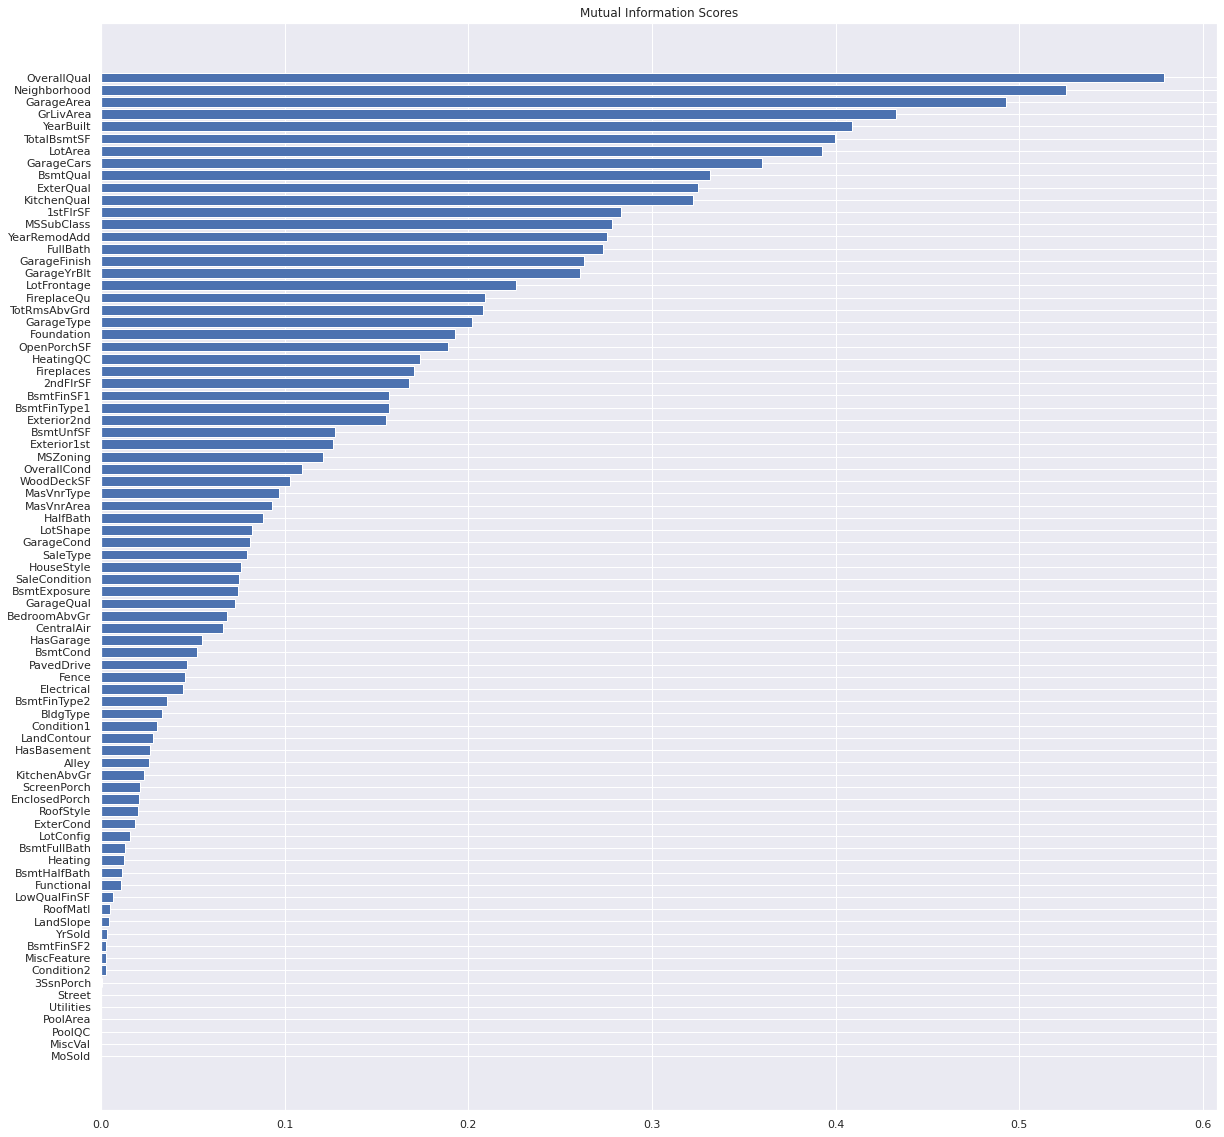

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,20))
    plt.barh(width, scores)    
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores)

In [ ]:
def drop_uninformative(df, mi_scores):
  return df.loc[:, mi_scores > 0.0]

X = train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

[14:30:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.13076491064606122

## Linear Regression with statmodels

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
feature_select = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'BsmtQual', 'ExterQual',
       'KitchenQual', 'MSSubClass', 'YearRemodAdd', 'FullBath',
       'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'FireplaceQu',
       'TotRmsAbvGrd']

fomula = 'SalePrice ~ ' + ' + '.join(feature_select)
fomula

'SalePrice ~ OverallQual + Neighborhood + GarageArea + GrLivArea + YearBuilt + TotalBsmtSF + LotArea + GarageCars + BsmtQual + ExterQual + KitchenQual + MSSubClass + YearRemodAdd + FullBath + GarageFinish + GarageYrBlt + LotFrontage + FireplaceQu + TotRmsAbvGrd'

In [ ]:
results = smf.ols(fomula, data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     114.1
Date:                Sun, 04 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:30:03   Log-Likelihood:                -17096.
No. Observations:                1460   AIC:                         3.435e+04
Df Residuals:                    1383   BIC:                         3.475e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -8

In [ ]:
# use log function which is in numpy
#train['SalePrice'] = np.log1p(train['SalePrice'])

# Check again for more normal distribution
#feature_distribution(train['SalePrice'])

In [ ]:
# One-hot encoding
def one_hot_endcoding(df):
  subset_train = pd.get_dummies(train)

  new_columns = []
  for i in subset_train.columns:
      new_name = re.sub(r'\W+', '_', i)
      if re.match('^\d', new_name):
          new_name = '_' + new_name
      new_columns.append(new_name)
  subset_train.columns = new_columns
  return subset_train
  
subset_train = one_hot_endcoding(train[feature_select])
print('Final data shape:', subset_train.shape)
subset_train.head()

Final data shape: (1460, 335)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,_1stFlrSF,_2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,_3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HasGarage,HasBasement,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,...,GarageQual_4,GarageQual_5,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,PavedDrive_1,PavedDrive_2,PavedDrive_3,PoolQC_0,PoolQC_2,PoolQC_4,PoolQC_5,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Linear Regression
**Train Test Split**

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [ ]:
from sklearn.model_selection import train_test_split
data_X_train, X_test, data_y_train, y_test = train_test_split(subset_train, train['SalePrice'], test_size=0.3, random_state=101)
print('Shape')
print('X_train: ' + str(data_X_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_train: ' + str(data_y_train.shape))
print('y_test: ' + str(y_test.shape))

Shape
X_train: (1022, 335)
X_test: (438, 335)
y_train: (1022,)
y_test: (438,)


**Linear Regression**

In [ ]:
#Train the model
from sklearn import linear_model
lr = linear_model.LinearRegression()

X_train = data_X_train
y_train = data_y_train
#Fit the model
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
#Score/Accuracy
print("Accuracy --> ", lr.score(X_test, y_test)*100)

Accuracy -->  100.0


In [ ]:
def plot_test_predict(test, predict):
  plt.figure(figsize=(10,10))
  plt.scatter(test, predict, c='crimson')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(predict), max(test))
  p2 = min(min(predict), min(test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

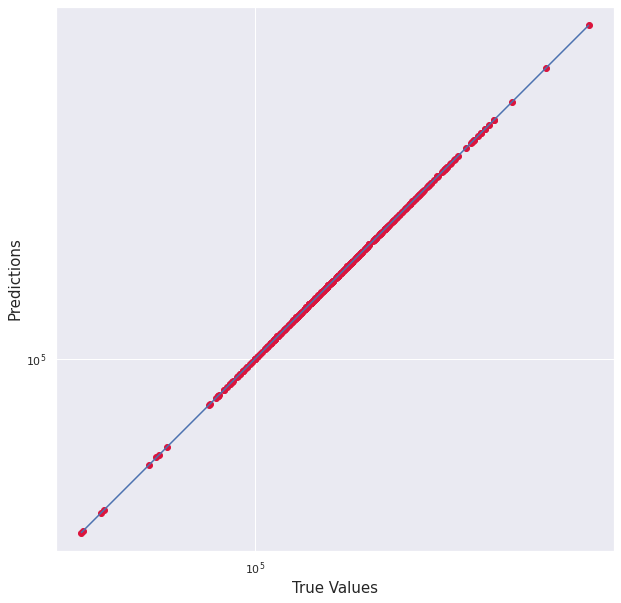

In [ ]:
plot_test_predict(y_test, y_pred_lr)

In [ ]:
pd.DataFrame({'test':y_test, 'predict': y_pred_lr})

,test,predict
1054,255000,255000.0
361,145000,145000.0
1282,150500,150500.0
161,412500,412500.0
515,402861,402861.0
...,...,...
249,277000,277000.0
467,146500,146500.0
650,205950,205950.0
48,113000,113000.0


**Random Forest Regression**

In [ ]:
#Train the model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000)

In [ ]:
X_train = data_X_train
y_train = data_y_train
#Fit
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

In [ ]:
#Score/Accuracy
print("Accuracy --> ", rfr.score(X_test, y_test)*100)

Accuracy -->  99.26537921115147


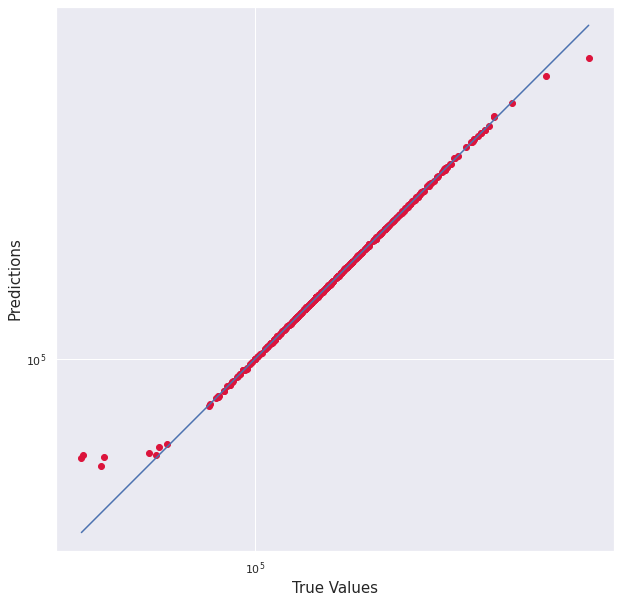

In [ ]:
plot_test_predict(y_test, y_pred_rfr)

**Gradient Boosting Regressor**

In [ ]:
#Train the model
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

In [ ]:
X_train = data_X_train
y_train = data_y_train
#Fit
GBR.fit(X_train, y_train)
y_pred_GBR = GBR.predict(X_test)

In [ ]:
print("Accuracy --> ", GBR.score(X_test, y_test)*100)

Accuracy -->  99.75433467998536


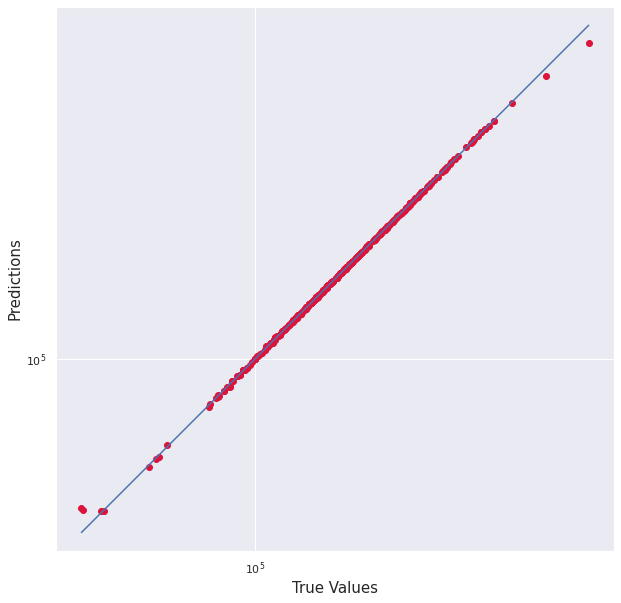

In [ ]:
plot_test_predict(y_test, y_pred_GBR)